In [1]:
import psrchive
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, StrMethodFormatter
import numpy as np
from scipy.signal import chirp, find_peaks, peak_widths
from scipy.optimize import curve_fit
import scipy.optimize as opt
from scipy.cluster.vq import kmeans, vq 
import scipy.stats as stats
from scipy.stats import vonmises
from scipy import signal
from scipy import constants
from matplotlib import gridspec
import uncertainties as u
from uncertainties import unumpy as unp
import math
from uncertainties import umath
from scipy.signal import medfilt
from scipy.stats import chisquare

### Define the Functions

In [2]:
#This function is used to insert an array before the last element of another array (created partly by ChatGPT)
def insert_array_before_last(arr, array_to_insert):
    if len(arr) >= 1:
        index_to_insert = len(arr) - 1
        array_to_insert_without_last = array_to_insert[:-1]  # Remove the last element
        arr = np.insert(arr, index_to_insert, array_to_insert_without_last)
        return arr
    else:
        print("The array must have at least one element to insert before the last index.")

In [3]:
def degrees_to_radians(degrees):
    radians = degrees * (math.pi / 180)
    return radians

In [4]:
def map_to_degrees(array):
    max_value = max(array)
    degrees_array = [(value / max_value) * 360 for value in array]
    return degrees_array

In [5]:
def val_to_deg(value, data):
    if isinstance(data, np.ndarray):
        degrees_value = (value / len(data)) * 360
        return degrees_value
    else:
        raise ValueError("data[k] should be a NumPy array")

In [6]:
def map_to_1024(array):
    max_value = max(array)
    degrees_array = [(value / 1023) * 360 for value in array]
    return degrees_array

In [7]:
def convert_subset_to_degrees(subset_array, full_rotation_length=1024):
    """
    Convert a subset array to degrees based on the assumption that a full rotation
    corresponds to the specified length.

    Parameters:
    - subset_array: numpy array, the subset of data to be converted to degrees.
    - full_rotation_length: int, the length of the full rotation (default is 1024).

    Returns:
    - degrees_array: numpy array, the converted values in degrees.
    """

    # Calculate the degrees per index
    degrees_per_index = 360 / full_rotation_length

    # Convert the subset array to degrees
    degrees_array = subset_array * degrees_per_index

    return degrees_array

In [8]:
def calculate_rms(array):
    """
    Calculate the Root Mean Square (RMS) of an array of values.

    Parameters:
    - array (numpy.ndarray): Input array of values.

    Returns:
    - float: RMS value.
    
    Function created partly by ChatGPT
    """
    if len(array) == 0:
        raise ValueError("Input array is empty")

    # Square each element in the array
    squared_values = np.square(array)

    # Calculate the mean of the squared values
    mean_squared = np.mean(squared_values)

    # Calculate the square root of the mean squared value
    rms = np.sqrt(mean_squared)

    return rms

In [9]:
#This function is used to smooth the data
def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed

In [10]:
#Function to add an a value to every third index of an array starting at index 1. Created to shift the param_arr positions.
def add_value_to_every_third(arr, value):
    for i in range(1, len(arr), 3):
        arr[i] += value
    return arr

# Example usage:
original_array = [1, 2, 3, 4, 5, 6, 7, 8, 9]
value_to_add = 10

result_array = add_value_to_every_third(original_array, value_to_add)

In [11]:
def apply_function_to_indices(input_array, function_to_apply):
    """
    Apply a specified function to every 2nd and 3rd index in an array.

    Parameters:
    - input_array: numpy array, the input array.
    - function_to_apply: function, the function to apply to the selected indices.

    Returns:
    - result_array: numpy array, the array with the function applied to selected indices.
    """

    result_array = input_array.copy()  # Create a copy to avoid modifying the original array

    # Apply the function to every 2nd and 3rd index
    result_array[1::2] = function_to_apply(result_array[1::2])
    result_array[2::3] = function_to_apply(result_array[2::3])

    return result_array


In [12]:
#Define a Gaussian and its different parameters
def gaussian(x, amp1,cen1,sigma1,b):
    #return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + b
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + b

In [13]:
#Define a profile with 4 aded gaussians
def _2gaussian(x, A1, p1, w1, A2, p2, w2, b):
#    return A1*np.exp(-4*np.log(2)*((x-p1)/w1)**2) + \
#            A2*np.exp(-4*np.log(2)*((x-p2)/w2)**2) + b
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + b

In [14]:
#Define a profile with 4 aded gaussians
def _3gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, b):
    #return A1*np.exp(-4*np.log(2)*((x-p1)/w1)**2) + \
    #        A2*np.exp(-4*np.log(2)*((x-p2)/w2)**2) + \
    #         A3*np.exp(-4*np.log(2)*((x-p3)/w3)**2) + b
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + b

In [15]:
#Define a profile with 4 aded gaussians
def _4gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, A4, p4, w4, b):
    #return A1*np.exp(-4*np.log(2)*((x-p1)/w1)**2) + \
    #        A2*np.exp(-4*np.log(2)*((x-p2)/w2)**2) + \
    #         A3*np.exp(-4*np.log(2)*((x-p3)/w3)**2) + \
    #          A4*np.exp(-4*np.log(2)*((x-p4)/w4)**2) + b
     return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + gaussian(x, A4, p4, w4, 0) + b

In [16]:
#Define a profile with 5 added gaussians
def _5gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, A4, p4, w4, A5, p5, w5, b):
    #return A1*np.exp(-4*np.log(2)*((x-p1)/w1)**2) + \
    #        A2*np.exp(-4*np.log(2)*((x-p2)/w2)**2) + \
    #         A3*np.exp(-4*np.log(2)*((x-p3)/w3)**2) + \
    #          A4*np.exp(-4*np.log(2)*((x-p4)/w4)**2) + \
    #           A5*np.exp(-4*np.log(2)*((x-p5)/w5)**2) + b
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + \
     gaussian(x, A4, p4, w4, 0) +  gaussian(x, A5, p5, w5, 0) + b

In [17]:
#Define a profile with 6 added gaussians
def _6gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, A4, p4, w4, A5, p5, w5, A6, p6, w6, b):
    #return A1*np.exp(-4*np.log(2)*((x-p1)/w1)**2) + \
    #        A2*np.exp(-4*np.log(2)*((x-p2)/w2)**2) + \
    #         A3*np.exp(-4*np.log(2)*((x-p3)/w3)**2) + \
    #          A4*np.exp(-4*np.log(2)*((x-p4)/w4)**2) + \
    #           A5*np.exp(-4*np.log(2)*((x-p5)/w5)**2) + \
    #            A6*np.exp(-4*np.log(2)*((x-p6)/w6)**2) + b
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + gaussian(x, A4, p4, w4, 0) + \
            gaussian(x, A5, p5, w5, 0) + gaussian(x, A6, p6, w6, 0) + b

In [18]:
#Define a profile with 7 added gaussians
def _7gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, A4, p4, w4, A5, p5, w5, A6, p6, w6, A7, p7, w7, b):
    #return A1*np.exp(-4*np.log(2)*((x-p1)/w1)**2) + \
    #        A2*np.exp(-4*np.log(2)*((x-p2)/w2)**2) + \
    #         A3*np.exp(-4*np.log(2)*((x-p3)/w3)**2) + \
    #          A4*np.exp(-4*np.log(2)*((x-p4)/w4)**2) + \
    #           A5*np.exp(-4*np.log(2)*((x-p5)/w5)**2) + \
    #            A6*np.exp(-4*np.log(2)*((x-p6)/w6)**2) + \
    #             A7*np.exp(-4*np.log(2)*((x-p7)/w7)**2) + b
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + gaussian(x, A4, p4, w4, 0) + \
            gaussian(x, A5, p5, w5, 0) + gaussian(x, A6, p6, w6, 0) + gaussian(x, A7, p7, w7, 0) + b

In [19]:
#Define a profile with 8 added gaussians
def _8gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, A4, p4, w4, A5, p5, w5, A6, p6, w6, A7, p7, w7, A8, p8, w8, b):
    #return A1*np.exp(-4*np.log(2)*((x-p1)/w1)**2) + \
    #        A2*np.exp(-4*np.log(2)*((x-p2)/w2)**2) + \
    #         A3*np.exp(-4*np.log(2)*((x-p3)/w3)**2) + \
    #          A4*np.exp(-4*np.log(2)*((x-p4)/w4)**2) + \
    #           A5*np.exp(-4*np.log(2)*((x-p5)/w5)**2) + \
    #            A6*np.exp(-4*np.log(2)*((x-p6)/w6)**2) + \
    #             A7*np.exp(-4*np.log(2)*((x-p7)/w7)**2) + \
    #              A8*np.exp(-4*np.log(2)*((x-p8)/w8)**2) + b
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + gaussian(x, A4, p4, w4, 0) +\
            gaussian(x, A5, p5, w5, 0) + gaussian(x, A6, p6, w6, 0) + gaussian(x, A7, p7, w7, 0) + gaussian(x, A8, p8, w8, 0) + b

In [20]:
#Define a profile with 9 added gaussians
def _9gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, A4, p4, w4, A5, p5, w5, A6, p6, w6, A7, p7, w7, A8, p8, w8, A9, p9, w9, b):
    #return A1*np.exp(-4*np.log(2)*((x-p1)/w1)**2) + \
    #        A2*np.exp(-4*np.log(2)*((x-p2)/w2)**2) + \
    #         A3*np.exp(-4*np.log(2)*((x-p3)/w3)**2) + \
    #          A4*np.exp(-4*np.log(2)*((x-p4)/w4)**2) + \
    #           A5*np.exp(-4*np.log(2)*((x-p5)/w5)**2) + \
    #            A6*np.exp(-4*np.log(2)*((x-p6)/w6)**2) + \
    #             A7*np.exp(-4*np.log(2)*((x-p7)/w7)**2) + \
    #              A8*np.exp(-4*np.log(2)*((x-p8)/w8)**2) + \
    #               A9*np.exp(-4*np.log(2)*((x-p9)/w9)**2) + b
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + gaussian(x, A4, p4, w4, 0) +\
            gaussian(x, A5, p5, w5, 0) + gaussian(x, A6, p6, w6, 0) + gaussian(x, A7, p7, w7, 0) + gaussian(x, A8, p8, w8, 0) +\
            gaussian(x, A9, p9, w9, 0) + b

In [21]:
#Define a profile with 10 added gaussians
def _10gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, A4, p4, w4, A5, p5, w5, A6, p6, w6,\
                A7, p7, w7, A8, p8, w8, A9, p9, w9, A10, p10, w10, b):
    #return A1*np.exp(-4*np.log(2)*((x-p1)/w1)**2) + \
    #        A2*np.exp(-4*np.log(2)*((x-p2)/w2)**2) + \
    #         A3*np.exp(-4*np.log(2)*((x-p3)/w3)**2) + \
    #          A4*np.exp(-4*np.log(2)*((x-p4)/w4)**2) + \
    #           A5*np.exp(-4*np.log(2)*((x-p5)/w5)**2) + \
    #            A6*np.exp(-4*np.log(2)*((x-p6)/w6)**2) + \
    #             A7*np.exp(-4*np.log(2)*((x-p7)/w7)**2) + \
    #              A8*np.exp(-4*np.log(2)*((x-p8)/w8)**2) + \
    #               A9*np.exp(-4*np.log(2)*((x-p9)/w9)**2) + \
    #                A10*np.exp(-4*np.log(2)*((x-p10)/w10)**2) + b
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + gaussian(x, A4, p4, w4, 0) +\
            gaussian(x, A5, p5, w5, 0) + gaussian(x, A6, p6, w6, 0) + gaussian(x, A7, p7, w7, 0) + gaussian(x, A8, p8, w8, 0) +\
            gaussian(x, A9, p9, w9, 0) + gaussian(x, A10, p10, w10, 0) + b

In [22]:
#This function deterrmines which number of added gaussians to return depending on the iteration
def which_gauss(i, xdata, p0_arr):
        gauss_arr = []
        if i == 1:
            gauss_arr = gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3])
        elif i == 2:
            gauss_arr = _2gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6])
        elif i == 3:
            gauss_arr = _3gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9])
        elif i == 4:
            gauss_arr = _4gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9], p0_arr[10], p0_arr[11], p0_arr[12])
        elif i == 5:
            gauss_arr = _5gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9], p0_arr[10], p0_arr[11], p0_arr[12], p0_arr[13], p0_arr[14], p0_arr[15])
        elif i == 6:
            gauss_arr = _6gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9], p0_arr[10], p0_arr[11], p0_arr[12], p0_arr[13], p0_arr[14], p0_arr[15],\
                              p0_arr[16], p0_arr[17], p0_arr[18])    
        elif i == 7:
            gauss_arr = _7gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9], p0_arr[10], p0_arr[11], p0_arr[12], p0_arr[13], p0_arr[14], p0_arr[15],\
                              p0_arr[16], p0_arr[17], p0_arr[18], p0_arr[19], p0_arr[20], p0_arr[21])
        elif i == 8:
            gauss_arr = _8gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9], p0_arr[10], p0_arr[11], p0_arr[12], p0_arr[13], p0_arr[14], p0_arr[15],\
                              p0_arr[16], p0_arr[17], p0_arr[18], p0_arr[19], p0_arr[20], p0_arr[21], p0_arr[22], p0_arr[23],\
                              p0_arr[24])  
        elif i == 9:
            gauss_arr = _9gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9], p0_arr[10], p0_arr[11], p0_arr[12], p0_arr[13], p0_arr[14], p0_arr[15],\
                              p0_arr[16], p0_arr[17], p0_arr[18], p0_arr[19], p0_arr[20], p0_arr[21], p0_arr[22], p0_arr[23],\
                              p0_arr[24], p0_arr[25], p0_arr[26], p0_arr[27])          
        elif i == 10:
            gauss_arr = _10gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9], p0_arr[10], p0_arr[11], p0_arr[12], p0_arr[13], p0_arr[14], p0_arr[15],\
                              p0_arr[16], p0_arr[17], p0_arr[18], p0_arr[19], p0_arr[20], p0_arr[21], p0_arr[22], p0_arr[23],\
                              p0_arr[24], p0_arr[25], p0_arr[26], p0_arr[27], p0_arr[28], p0_arr[29], p0_arr[30])
        return(gauss_arr)


In [23]:
#Define the function to minimize with the least_squares algorithm
def fit_func(p, x, y):
    if np.any(p<0):
        return np.inf
    return y - gaussian(x, *p)

In [24]:
def convert_allvals_to_deg(x_on_pulse_aligned, pulse_center, first_cutoff_idx, last_cutoff_idx, param_arr):
    x_on_pulse_aligned_deg = convert_subset_to_degrees(x_on_pulse_aligned)
    first_cutoff_deg = convert_subset_to_degrees(first_cutoff_idx)
    shift_amount = int(first_cutoff_idx)
    last_cutoff_deg = convert_subset_to_degrees(last_cutoff_idx)
    param_arr_deg = apply_function_to_indices(param_arr, convert_subset_to_degrees)
    param_arr_deg_aligned = add_value_to_every_third(param_arr_deg, first_cutoff_deg)
    pulse_center_deg = convert_subset_to_degrees(pulse_center)
    
    return(x_on_pulse_aligned_deg, pulse_center_deg, first_cutoff_deg, last_cutoff_deg, param_arr_deg, param_arr_deg_aligned)

In [25]:
#Define a function which does all the plotting
def plotting(iteration, original_data, x, param_arr, on_pulse, resids, first_cutoff_idx, last_cutoff_idx, pulse_center, \
             chi_squared, show_all = False):
            #Get the array for the Gaussian which will be plotted
            gaussian_plot = which_gauss(iteration, x, param_arr)
            shift_amount = int(first_cutoff_idx)
            gaussian_plot_aligned = np.roll(gaussian_plot, shift_amount)
            param_arr_aligned = add_value_to_every_third(param_arr, first_cutoff_idx)
            x_on_pulse = np.arange(0,len(on_pulse))
            x_on_pulse_aligned = x_on_pulse + first_cutoff_idx
            x_on_pulse_aligned_deg, pulse_center_deg, first_cutoff_deg, last_cutoff_deg, param_arr_deg, param_arr_deg_aligned, \
            = convert_allvals_to_deg(x_on_pulse_aligned, pulse_center, first_cutoff_idx, last_cutoff_idx, param_arr)
            
            #Create subplots to plot both the data compared to the original data and the residuals
            fig, axs = plt.subplots(2, 1)
            fig.set_figheight(10)
            fig.set_figwidth(10)
            

            line1 = axs[0].plot(x_on_pulse_aligned_deg, gaussian_plot_aligned[first_cutoff_idx:last_cutoff_idx+1], color='blue', label='Fit')
            line2 = axs[0].plot(x_on_pulse_aligned_deg, original_data[first_cutoff_idx:last_cutoff_idx+1], color='silver', label='Original Data')
            #axs[0].plot(x_on_pulse_aligned_deg, on_pulse, color='green', label='Fitted Data')
            line3 = axs[0].axvline(x=first_cutoff_deg, color = 'r', label='First Cutoff Line')
            line4 = axs[0].axvline(x=last_cutoff_deg, color = 'darkred', label='Last Cutoff Line')
            line5 = axs[0].axvline(x=pulse_center_deg, color='r', linestyle='--', label='Pulse Center')
            axs[0].set_title('Resulting On-Pulse Fit', fontsize=10)
            axs[0].set_xlabel('Pulse Phase [deg]', fontsize=10)
            axs[0].set_ylabel('Intensity [arbitrary units]', fontsize=10)
            # Adding legend with the goodness of fit value
            legend_label = f'$\chi^2$ value: {chi_squared}'
            axs[0].legend(title = legend_label)
            #plt.legend(title='abc xyz')
            
            axs[1].plot(x_on_pulse_aligned_deg, resids, label='Residuals')
            axs[1].axis('auto')
            #axs[1, 0].set(xlim=(-3, 3), ylim=(-3, 3))
            axs[1].set_title('On-Pulse Residuals', fontsize=10)
            axs[1].set_xlabel('Pulse Phase [deg]', fontsize=10)
            axs[1].set_ylabel('Intensity [arbitrary units]', fontsize=10)
            axs[1].legend()

            plt.show()
            plt.close()
        
            #--------------------------
            
            #Create a new figure to plot all of the separate Gaussians
            plt.figure(figsize=(12,6))
            
            #Depeding on the amount of Gaussians, find how many to plot and plot them
            if show_all == True:
                if iteration == 1:                   
                    pars_1 = param_arr[0:3]
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
            
                    plt.plot(original_data, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.axvline(x=first_cutoff_idx, color = 'r')
                    plt.axvline(x=last_cutoff_idx, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
        
                elif iteration == 2:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_added = _2gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[-1])
                
                    plt.plot(original_data, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff_idx, color = 'r')
                    plt.axvline(x=last_cutoff_idx, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
            
                elif iteration == 3:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_added = _3gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[-1])
            
            
                    plt.plot(original_data, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff_idx, color = 'r')
                    plt.axvline(x=last_cutoff_idx, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
            
                elif iteration == 4:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
                    pars_4 = param_arr[9:12]
                
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_peak4 = gaussian(x, *pars_4, param_arr[-1])
                    gauss_added = _4gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[9], param_arr[10],\
                               param_arr[11], param_arr[-1])
            
            
                    plt.plot(original_data, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_peak4, label='Gaussian 4')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff_idx, color = 'r')
                    plt.axvline(x=last_cutoff_idx, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
                    
            
                elif iteration == 5:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
                    pars_4 = param_arr[9:12]
                    pars_5 = param_arr[12:15]
                    
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_peak4 = gaussian(x, *pars_4, param_arr[-1])
                    gauss_peak5 = gaussian(x, *pars_5, param_arr[-1])
                    gauss_added = _5gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[9], param_arr[10],\
                               param_arr[11], param_arr[12], param_arr[13], param_arr[14], param_arr[-1])
                    
                    #plt.figure().set_figheight(5)
                    #plt.figure().set_figwidth(10)
                    plt.plot(original_data, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_peak4, label='Gaussian 4')
                    plt.plot(x, gauss_peak5, label='Gaussian 5')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff_idx, color = 'r')
                    plt.axvline(x=last_cutoff_idx, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
                                
                elif iteration == 6:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
                    pars_4 = param_arr[9:12]
                    pars_5 = param_arr[12:15]
                    pars_6 = param_arr[15:18]
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_peak4 = gaussian(x, *pars_4, param_arr[-1])
                    gauss_peak5 = gaussian(x, *pars_5, param_arr[-1])
                    gauss_peak6 = gaussian(x, *pars_6, param_arr[-1])
                    gauss_added = _6gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[9], param_arr[10],\
                               param_arr[11], param_arr[12], param_arr[13], param_arr[14], param_arr[15], param_arr[16], \
                               param_arr[17], param_arr[-1])
            
                
                    plt.plot(original_data, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_peak4, label='Gaussian 4')
                    plt.plot(x, gauss_peak5, label='Gaussian 5')
                    plt.plot(x, gauss_peak6, label='Gaussian 6')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff_idx, color = 'r')
                    plt.axvline(x=last_cutoff_idx, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
                    
                elif iteration == 7:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
                    pars_4 = param_arr[9:12]
                    pars_5 = param_arr[12:15]
                    pars_6 = param_arr[15:18]
                    pars_7 = param_arr[18:21]
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_peak4 = gaussian(x, *pars_4, param_arr[-1])
                    gauss_peak5 = gaussian(x, *pars_5, param_arr[-1])
                    gauss_peak6 = gaussian(x, *pars_6, param_arr[-1])
                    gauss_peak7 = gaussian(x, *pars_7, param_arr[-1])
                    gauss_added = _7gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[9], param_arr[10],\
                               param_arr[11], param_arr[12], param_arr[13], param_arr[14], param_arr[15], param_arr[16], \
                               param_arr[17], param_arr[18], param_arr[19], param_arr[20], param_arr[-1])
                    
            
                    plt.plot(original_data, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_peak4, label='Gaussian 4')
                    plt.plot(x, gauss_peak5, label='Gaussian 5')
                    plt.plot(x, gauss_peak6, label='Gaussian 6')
                    plt.plot(x, gauss_peak7, label='Gaussian 7')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff_idx, color = 'r')
                    plt.axvline(x=last_cutoff_idx, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
                    
                elif iteration == 8:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
                    pars_4 = param_arr[9:12]
                    pars_5 = param_arr[12:15]
                    pars_6 = param_arr[15:18]
                    pars_7 = param_arr[18:21]
                    pars_8 = param_arr[21:24]
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_peak4 = gaussian(x, *pars_4, param_arr[-1])
                    gauss_peak5 = gaussian(x, *pars_5, param_arr[-1])
                    gauss_peak6 = gaussian(x, *pars_6, param_arr[-1])
                    gauss_peak7 = gaussian(x, *pars_7, param_arr[-1])
                    gauss_peak8 = gaussian(x, *pars_8, param_arr[-1])
                    gauss_added = _8gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[9], param_arr[10],\
                               param_arr[11], param_arr[12], param_arr[13], param_arr[14], param_arr[15], param_arr[16], \
                               param_arr[17], param_arr[18], param_arr[19], param_arr[20], param_arr[21], param_arr[22], \
                               param_arr[23], param_arr[-1])
            
                    plt.plot(original_data, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_peak4, label='Gaussian 4')
                    plt.plot(x, gauss_peak5, label='Gaussian 5')
                    plt.plot(x, gauss_peak6, label='Gaussian 6')
                    plt.plot(x, gauss_peak7, label='Gaussian 7')
                    plt.plot(x, gauss_peak8, label='Gaussian 8')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff_idx, color = 'r')
                    plt.axvline(x=last_cutoff_idx, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
                
                elif iteration == 9:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
                    pars_4 = param_arr[9:12]
                    pars_5 = param_arr[12:15]
                    pars_6 = param_arr[15:18]
                    pars_7 = param_arr[18:21]
                    pars_8 = param_arr[21:24]
                    pars_9 = param_arr[24:27]
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_peak4 = gaussian(x, *pars_4, param_arr[-1])
                    gauss_peak5 = gaussian(x, *pars_5, param_arr[-1])
                    gauss_peak6 = gaussian(x, *pars_6, param_arr[-1])
                    gauss_peak7 = gaussian(x, *pars_7, param_arr[-1])
                    gauss_peak8 = gaussian(x, *pars_8, param_arr[-1])
                    gauss_peak9 = gaussian(x, *pars_9, param_arr[-1])
                    gauss_added = _9gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[9], param_arr[10],\
                               param_arr[11], param_arr[12], param_arr[13], param_arr[14], param_arr[15], param_arr[16], \
                               param_arr[17], param_arr[18], param_arr[19], param_arr[20], param_arr[21], param_arr[22], \
                               param_arr[23], param_arr[24], param_arr[25], param_arr[26], param_arr[-1])
                    
            
                    plt.plot(original_data, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_peak4, label='Gaussian 4')
                    plt.plot(x, gauss_peak5, label='Gaussian 5')
                    plt.plot(x, gauss_peak6, label='Gaussian 6')
                    plt.plot(x, gauss_peak7, label='Gaussian 7')
                    plt.plot(x, gauss_peak8, label='Gaussian 8')
                    plt.plot(x, gauss_peak9, label='Gaussian 9')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff_idx, color = 'r')
                    plt.axvline(x=last_cutoff_idx, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
                    
                elif iteration == 10:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
                    pars_4 = param_arr[9:12]
                    pars_5 = param_arr[12:15]
                    pars_6 = param_arr[15:18]
                    pars_7 = param_arr[18:21]
                    pars_8 = param_arr[21:24]
                    pars_9 = param_arr[24:27]
                    pars_10 = param_arr[27:30]
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_peak4 = gaussian(x, *pars_4, param_arr[-1])
                    gauss_peak5 = gaussian(x, *pars_5, param_arr[-1])
                    gauss_peak6 = gaussian(x, *pars_6, param_arr[-1])
                    gauss_peak7 = gaussian(x, *pars_7, param_arr[-1])
                    gauss_peak8 = gaussian(x, *pars_8, param_arr[-1])
                    gauss_peak9 = gaussian(x, *pars_9, param_arr[-1])
                    gauss_peak10 = gaussian(x, *pars_10, param_arr[-1])
                    gauss_added = _10gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[9], param_arr[10],\
                               param_arr[11], param_arr[12], param_arr[13], param_arr[14], param_arr[15], param_arr[16], \
                               param_arr[17], param_arr[18], param_arr[19], param_arr[20], param_arr[21], param_arr[22], \
                               param_arr[23], param_arr[24], param_arr[25], param_arr[26], param_arr[27], param_arr[28], \
                               param_arr[29], param_arr[-1])
            
                    plt.plot(original_data, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_peak4, label='Gaussian 4')
                    plt.plot(x, gauss_peak5, label='Gaussian 5')
                    plt.plot(x, gauss_peak6, label='Gaussian 6')
                    plt.plot(x, gauss_peak7, label='Gaussian 7')
                    plt.plot(x, gauss_peak8, label='Gaussian 8')
                    plt.plot(x, gauss_peak9, label='Gaussian 9')
                    plt.plot(x, gauss_peak10, label='Gaussian 10')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff_idx, color = 'r')
                    plt.axvline(x=last_cutoff_idx, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
            
            
            #Plot parameters
            plt.title('All Single Gaussian + Data')
            plt.xlabel('Pulse Phase [Bins]')
            plt.ylabel('Intensity [arbitrary units]')
            plt.legend()
            plt.show()
            plt.close()

#### Fitting Algorithm

In [26]:
def select_longest_range_above_cutoff(data, cutoff, min_consecutive_above=3):
    # Create a boolean array indicating whether each element in 'data' is above or equal to 'cutoff'
    above_threshold = data >= cutoff

    # Initialize variables to keep track of the longest consecutive sequence    
    max_start = -1
    max_end = -1
    current_start = -1
    current_end = -1
    max_length = 0
    current_length = 0
    
    # Iterate through the elements of 'above_threshold'
    for i, above in enumerate(above_threshold):
        if above:
            # Increment the length of the current consecutive sequence
            current_length += 1
            # Update start and end indices if the current sequence just started
            if current_start == -1:
                current_start = i
            current_end = i
        else:
            # Check if the current consecutive sequence is longer than the previous longest
            if current_length >= min_consecutive_above:
                if current_length > max_length:
                    max_start = current_start
                    max_end = current_end
                    max_length = current_length
            # Reset current sequence variables when the sequence is interrupted
            current_length = 0
            current_start = -1
            current_end = -1

    # Check if the last sequence is the longest
    if current_length >= min_consecutive_above and current_length > max_length:
        max_start = current_start
        max_end = current_end
    
    #Since the cutoff is at 0.10, we will widen the range to include the entire pulse, so include +-50 indexes from the 10% limit
    max_start = max_start - 30
    max_end = max_end + 30
    
     # Return the longest consecutive sequence and its start and end indices
    return data[max_start:max_end + 1], max_start, max_end

In [27]:
def gauss_fit(data, iteration, param_arr, resids_params, mean_baseline = False, smooth = False, remove_baseline = True, \
              debug_plots = False):
    force_smooth = False
    resids = []
    popt_gauss = []
    gauss_arr = []
    chi_squared_rounded = []
    #Create a copy of the original data
    original_data = data
    #Simplify the data so we don't have to call k every time
    data = data
    #Select the index of the max of ydata
    arrmax = np.argmax(data)
    #Select the max value in the y data
    max_value = data[arrmax]
    #Calculate % of that max value that will be the cutoff for the fit
    cutoff = max_value*0.10
    #data_rms = calculate_rms(data)
    #cutoff = data_rms
    
    #x_list = np.arange(len(data))
    #x = map_to_degrees(x_list)
    
    
    #Option to smooth the data in order to allow for easier fitting
    if smooth == True:
        #smooth triangle algorithm
        data = smoothTriangle(data, 4)
        #savgol filter for smoothing
        #data = signal.savgol_filter(data, len(on_pulse), 5) # order of fitted polynomial
    
    #Declare some arrays that we will want to use after the follow if-statement
    off_pulse_mean = []
    off_pulse_mean_normalized = []
    
    #if-statement that removes any baseline to the data
    if remove_baseline == True:
        #Cutoff value which defines what the baseline is
        baseline_cutoff = max_value*0.10 #Can use 0.20 if profiles are noisy
        cutoff_index_temp = []
        cutoff_value_temp = []
        #Make a list of the indexes of the values in the data which are lower than the cutoff
        for idx, i in enumerate(data):
            if i >= baseline_cutoff:
                cutoff_index_temp.append(idx)
                cutoff_value_temp.append(i)
                
        #Determine first and last value where the on pulse starts and stops
        first_cutoff_idx = cutoff_index_temp[0]
        last_cutoff_idx = cutoff_index_temp[-1]
        first_cutoff_value = cutoff_value_temp[0]
        last_cutoff_value = cutoff_value_temp[-1]
        
        #Remove the on pulse from the data
        off_pulse = np.delete(data,(np.r_[first_cutoff_idx:last_cutoff_idx]))
        #Calculate the RMS of the off_pulse
        off_pulse_rms = calculate_rms(off_pulse)
        #Calculate the Standard deviation of the off-pulse
        off_pulse_std = np.nanstd(off_pulse)
        #Calculate the median of the off-pulse
        off_pulse_median = np.nanstd(off_pulse)
        #Calculate the 2 sigma spead of the off pulse
        off_pulse_spread_positive = off_pulse_median + 2*off_pulse_std
        off_pulse_spread_negative = off_pulse_median - 2*off_pulse_std
        off_pulse_spread = [off_pulse_spread_positive, off_pulse_spread_negative]
        #Find the mean value of the off pulse
        off_pulse_mean = np.mean(off_pulse)
        #Apply the removal of the baseline
        data = data - off_pulse_mean
        
        #Select the frequency channel number to normalise
        data_current = data
        #Perform the normalisation from 0 to 1 on the y axis
        data_normalized = (data_current - np.min(data_current))/(np.max(data_current) - np.min(data_current))
        #Append normalized value to array for normalized values
        data = data_normalized
        
        #Now we want the mean value of the baseline once it has been normalized
        off_pulse_normalized = np.delete(data,(np.r_[first_cutoff_idx:last_cutoff_idx]))
        off_pulse_mean_normalized = np.mean(off_pulse_normalized)
        
    #These lines set all the baseline to the mean value
    if mean_baseline == True:
        #data[data < baseline_cutoff] = off_pulse_mean_normalized
        #print('Baseline_Cutoff: ' + str(baseline_cutoff))
        data_last_idx = len(data) -1
        data[np.r_[0:first_cutoff_idx,last_cutoff_idx:data_last_idx]] = off_pulse_mean_normalized
    
    cutoff_index = []

    on_pulse_arr, first_cutoff_idx, last_cutoff_idx = select_longest_range_above_cutoff(data, cutoff)
    #print('on_pulse_arr_new len: ' + str(len(on_pulse_arr_new)))
    #plt.plot(x[first_cutoff:last_cutoff+1], on_pulse_arr)
    #plt.show()
    #plt.close()
    #print(start_cutoff)
    
    #print('new cutoffs data length: ' + str(len(data[int(start_cutoff):int(end_cutoff)+1])))
    
    #Create an array to select only on-pulse
    #on_pulse_arr = []
    #for i in data:
    #    if i >= cutoff:
    #        on_pulse_arr = np.append(on_pulse_arr, i)
    
    #Create an array with the indexes of the on pulse
    #for idx, i in enumerate(data):
    #    if i >= cutoff:
    #        cutoff_index = np.append(cutoff_index, idx)
            
    #Get the first and last index of the on pulse
    #first_cutoff = x[int(cutoff_index[0])]
    #last_cutoff = x[int(cutoff_index[-1])]
    #first_cutoff = int(cutoff_index[0])
    #last_cutoff = int(cutoff_index[-1])
    #Get the center index of the pulse
    pulse_center = (first_cutoff_idx + last_cutoff_idx)/2
      
    
    #Define a list of x values
    x = np.arange(len(data))
#    x = np.linspace(start=0, stop=1023, num=10000)
    x_on_pulse = np.arange(len(on_pulse_arr))
    #x_on_pulse = np.arange(len(data[first_cutoff:last_cutoff+1]))
    #print('On Pulse length: ' + str(len(on_pulse_arr)))
    #print('Cutoff Array length: ' + str(len(data[first_cutoff:last_cutoff+1])))
    #print('On Pulse max: ' + str(max(on_pulse_arr)))
    #print('On Pulse x: ' + str(len(x_on_pulse)))
    #print('On Pulse Index at max: ' + str(np.argmax(on_pulse_arr)))
    #print('On Pulse Sigma: ' + str(round(len(on_pulse_arr)/5)))
    #print('x_on_pulse length: ' +str(len(x_on_pulse)))
    #print('on_pulse_arr:' + str(on_pulse_arr))

    #Set the guesses for the initial parameters
    initial_amp = 1.0
    initial_sigma = round(len(on_pulse_arr)/5)
    initial_center = np.argmax(on_pulse_arr)
    initial_b = 0
    initial_guess = []
    initial_guess = [initial_amp, initial_center, initial_sigma, initial_b]
    
    #Append the appropriate guess parameters to the appropriate array
    if iteration == 2:
        initial_guess2 = []
        initial_guess2 = insert_array_before_last(param_arr, resids_params)
    elif iteration == 3:
        initial_guess3 = []
        initial_guess3 = np.append(initial_guess[:-1], param_arr)
    elif iteration == 4:
        initial_guess4 = []
        initial_guess4 = np.append(initial_guess[:-1], param_arr)
    elif iteration == 5:    
        initial_guess5 = []
        initial_guess5 = np.append(initial_guess[:-1], param_arr)
    elif iteration == 6:    
        initial_guess6 = []
        initial_guess6 = np.append(initial_guess[:-1], param_arr)
    elif iteration == 7:    
        initial_guess7 = []
        initial_guess7 = np.append(initial_guess[:-1], param_arr)
    elif iteration == 8:    
        initial_guess8 = []
        initial_guess8 = np.append(initial_guess[:-1], param_arr)
    elif iteration == 9:    
        initial_guess9 = []
        initial_guess9 = np.append(initial_guess[:-1], param_arr)
    elif iteration == 10:    
        initial_guess10 = []
        initial_guess10 = np.append(initial_guess[:-1], param_arr)
    
    #Set the bounds on the fitting algorithm
    len_arr = len(on_pulse_arr)
    
    #Bound variables
    min_bound_amp = cutoff
    min_bound_p = 0
    min_bound_width = len(on_pulse_arr)/10000
    min_bound_b = 0
    
    max_bound_amp = np.max(on_pulse_arr)
    max_bound_p = len(on_pulse_arr)
    max_bound_width = len(on_pulse_arr)
    max_bound_b = np.min(on_pulse_arr)
    
    bounds1 = ((min_bound_amp,min_bound_p,min_bound_width,min_bound_b), (max_bound_amp, max_bound_p, max_bound_width, max_bound_b))
    bounds2 = ((min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_b), \
               (max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, \
                max_bound_b))
    bounds3 = ((min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_b), \
               (max_bound_amp, max_bound_p, max_bound_width, max_bound_amp,max_bound_p, \
                max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_b))
    bounds4 = ((min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_b), \
               (max_bound_amp,max_bound_p, max_bound_width, max_bound_amp,max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp,max_bound_p, max_bound_width, max_bound_b))
    bounds5 = ((min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_b), \
               (max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, max_bound_p,max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp,max_bound_p, max_bound_width, max_bound_amp, max_bound_p,\
                max_bound_width, max_bound_b))
    bounds6 = ((min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_b), \
               (max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width,max_bound_amp, max_bound_p, max_bound_width,max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_b))
    bounds7 = ((min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_b), \
               (max_bound_amp, max_bound_p, max_bound_width,max_bound_amp, max_bound_p,max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width,max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_b))
    bounds8 = ((min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_b), \
               (max_bound_amp,max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_b))
    bounds9 = ((min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_b), \
               (max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_b))
    bounds10 = ((min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_amp,min_bound_p,min_bound_width,min_bound_b), \
               (max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_amp, \
                max_bound_p, max_bound_width, max_bound_amp, max_bound_p, max_bound_width, max_bound_b))
    
    #Here we run the fitting code given the appropriate parameters
    if iteration == 1:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess, bounds=bounds1, method='trf', maxfev=1000000)
        gauss_arr = gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3])
    elif iteration == 2:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_2gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess2, bounds=bounds2, method='trf', maxfev=1000000)
        gauss_arr = _2gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4], popt_gauss[5], popt_gauss[6])
    elif iteration == 3:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_3gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess3, bounds=bounds3, method='trf', maxfev=1000000)
        gauss_arr = _3gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9])
    elif iteration == 4:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_4gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess4, bounds=bounds4, method='trf', maxfev=1000000)
        gauss_arr = _4gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9], popt_gauss[10],\
                               popt_gauss[11], popt_gauss[12])
    elif iteration == 5:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_5gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess5, bounds=bounds5, method='trf', maxfev=1000000)
        gauss_arr = _5gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9], popt_gauss[10],\
                               popt_gauss[11], popt_gauss[12], popt_gauss[13], popt_gauss[14], popt_gauss[15])
    elif iteration == 6:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_6gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess6, bounds=bounds6, method='trf', maxfev=1000000)
        gauss_arr = _6gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9], popt_gauss[10],\
                               popt_gauss[11], popt_gauss[12], popt_gauss[13], popt_gauss[14], popt_gauss[15],\
                               popt_gauss[16], popt_gauss[17], popt_gauss[18])
    elif iteration == 7:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_7gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess7, bounds=bounds7, method='trf', maxfev=1000000)
        gauss_arr = _7gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9], popt_gauss[10],\
                               popt_gauss[11], popt_gauss[12], popt_gauss[13], popt_gauss[14], popt_gauss[15],\
                               popt_gauss[16], popt_gauss[17], popt_gauss[18], popt_gauss[19], popt_gauss[20], popt_gauss[21])
    elif iteration == 8:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_8gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess8, bounds=bounds8, method='trf', maxfev=1000000)
        gauss_arr = _8gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9], popt_gauss[10],\
                               popt_gauss[11], popt_gauss[12], popt_gauss[13], popt_gauss[14], popt_gauss[15],\
                               popt_gauss[16], popt_gauss[17], popt_gauss[18], popt_gauss[19], popt_gauss[20], popt_gauss[21],\
                               popt_gauss[22], popt_gauss[23], popt_gauss[24])
    elif iteration == 9:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_9gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess9, bounds=bounds9, method='trf', maxfev=1000000)
        gauss_arr = _9gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9], popt_gauss[10],\
                               popt_gauss[11], popt_gauss[12], popt_gauss[13], popt_gauss[14], popt_gauss[15],\
                               popt_gauss[16], popt_gauss[17], popt_gauss[18], popt_gauss[19], popt_gauss[20], popt_gauss[21],\
                               popt_gauss[22], popt_gauss[23], popt_gauss[24], popt_gauss[25], popt_gauss[26], popt_gauss[27])
    elif iteration == 10:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_10gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess10, bounds=bounds10, method='trf', maxfev=1000000)
        gauss_arr = _10gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9], popt_gauss[10],\
                               popt_gauss[11], popt_gauss[12], popt_gauss[13], popt_gauss[14], popt_gauss[15],\
                               popt_gauss[16], popt_gauss[17], popt_gauss[18], popt_gauss[19], popt_gauss[20], popt_gauss[21],\
                               popt_gauss[22], popt_gauss[23], popt_gauss[24], popt_gauss[25], popt_gauss[26], popt_gauss[27],\
                               popt_gauss[28], popt_gauss[29], popt_gauss[30])
    else:
        #We stop after 10 Gaussian fits
        print("Trying to fit more than 10 Gaussians... There is most likely a problem...")
        resids = [100]
        print("Forcing smoothing of the profile to try to get a better fit")
        #Set force_smooth to true so that we can try again with smoothed data
        force_smooth = True
        return(resids, popt_gauss, gauss_arr, on_pulse_arr, off_pulse_rms, x, resids_params, first_cutoff_idx, last_cutoff_idx, pulse_center, \
           force_smooth, chi_squared_rounded)     
    
    #center_difference = initial_center - gaussian_fit_center
#     shift_amount = int(first_cutoff_idx)
#     x_first_cutoff = np.where(gauss_arr>=first_cutoff_value)[0][0]
#     x_last_cutoff = np.where(gauss_arr>=last_cutoff_value)[0][0]
#    x_first_cutoff = round((first_cutoff_idx / len(data))*len(gauss_arr))
#    x_last_cutoff = round((last_cutoff_idx / len(data))*len(gauss_arr))
#    print(f"first_cutoff_value = {first_cutoff_value}")
#    print(f"last_cutoff_value = {last_cutoff_value}")
#    print(f"first_cutoff_idx = {first_cutoff_idx}")
#    print(f"last_cutoff_idx = {last_cutoff_idx}")
#    print(f"x_first_cutoff = {x_first_cutoff}")
#    print(f"x_last_cutoff = {x_last_cutoff}")
#    print(f"arr stop = {((int(x_last_cutoff)+1)-int(x_first_cutoff))}")
    shift_amount = int(first_cutoff_idx)
    gauss_arr_full = np.roll(gauss_arr, shift_amount)
    
    #gauss_arr_full = np.roll(gauss_arr, x_first_cutoff)
    
    on_pulse_resulting_gauss = gauss_arr[0:((int(last_cutoff_idx)+1)-int(first_cutoff_idx))]
    #print(f"len x = {len(x)}")
    #print(f"len gauss_arr = {len(gauss_arr)}")
    #Get the residuals
    resids = on_pulse_arr - on_pulse_resulting_gauss
    resids_rms = calculate_rms(resids)
    
    
    if debug_plots == True:
        plt.plot(gauss_arr_full, label = 'fit')
        plt.plot(data, label = 'data')
        plt.title('test plot')
        plt.legend()
        plt.show()
        plt.close()
        plt.plot(on_pulse_resulting_gauss)
        plt.plot(on_pulse_arr)
        plt.show()
        plt.close()
        plt.plot(resids)
        
    #Calculate the Chi^2 value:
    chi_squared, p_val = chisquare(on_pulse_resulting_gauss,  f_exp=on_pulse_arr)
    chi_squared_rounded = round(chi_squared, 3)
    print('chi squared: ' + str(chi_squared_rounded))

    #Allow for smoothing of residuals
    if smooth == True:
        resids = smoothTriangle(resids, 2)
        
    #Here we will take the resulting residuals and fit a Gaussian to it in order to use these parameters in the next fit
    bounds_resids = ((np.max(resids)*0.90,0,len(resids)/1000,np.min(resids)), (np.max(resids), len(resids), round(len(resids)/4), 0))
    guess_resids = [np.max(resids), np.argmax(resids), round(len(resids)/10), np.min(resids)/2]
    resids_params, pcov_resids = opt.curve_fit(gaussian, x_on_pulse, resids, p0=guess_resids, bounds=bounds_resids, method='dogbox', maxfev=1000000)
    #Print the fit parameters returned by the fit algorithm
    resids_gauss_arr = gaussian(x_on_pulse, resids_params[0], resids_params[1], resids_params[2], resids_params[3])
    #print("resultant resids fit: Amp: " + str(resids_params[0]) + " Center: " + str(resids_params[1]) + " Width: " + str(resids_params[2]) + " y-intercept: " + str(resids_params[3]))
    #print('Guess: ' + str(guess_resids))
    #print("param_arr: " + str(popt_gauss))
    perr = np.sqrt(np.diag(pcov_gauss))
    #print('perr array: ' + str(perr))
    #print('1st perr: ' + str(perr[1]))
    
    if debug_plots == True:
        plt.plot(resids_gauss_arr)
        plt.title('residuals')
        plt.show()
        plt.close()
        
    #gauss_peak1 = gaussian(x, *resids_params)
    
    #plt.close()
    #plt.plot(original_data, 'r', label='Data')
    #plt.plot(x, gauss_peak1, label='Test')
    #plt.axvline(x=first_cutoff, color = 'r')
    #plt.axvline(x=last_cutoff, color = 'r')
    #plt.axvline(x=pulse_center, color='r', linestyle='--')
    #plt.show()
    #plt.close()
    
    return(resids, popt_gauss, gauss_arr_full, on_pulse_arr, off_pulse_rms, x, resids_params, first_cutoff_idx, last_cutoff_idx, pulse_center, \
           force_smooth, chi_squared_rounded)

-------------------------------------------------------------------------------------------

In [28]:
def calculate_snr(array, signal_start, signal_end):
    #Function created in part by ChatGPT
    #intensity = np.nanmean(array)
    time = np.arange(0, len(array))
    noise_start = 0
    noise_end = len(time)

    # Find the indices corresponding to the signal and noise regions
    signal_indices = np.where((time >= signal_start) & (time <= signal_end))[0]
    noise_indices = np.where((time >= noise_start) & (time <= noise_end))[0]

    # Calculate the signal level (average intensity in signal region)
    signal_level = np.nanmean(array[signal_indices]) if len(signal_indices) > 0 else np.nan

    # Calculate the noise level (standard deviation of intensity in noise region)
    noise_level = np.nanstd(array[noise_indices]) if len(noise_indices) > 0 else np.nan

    # Calculate SNR
    snr = signal_level / noise_level if noise_level != 0 else np.inf

    return(snr)

In [29]:
def calculate_10percent(dataset):
    max_value = max(dataset)
    half_max = max_value / 10

    # Find the indices where the dataset crosses the half-maximum value
    indices = [index for index, value in enumerate(dataset) if value >= half_max]

    if len(indices) >= 2:
        fwhm = indices[-1] - indices[0] + 1
        return fwhm
    else:
        return None

In [30]:
def calculate_fwhm(dataset):
    max_value = max(dataset)
    half_max = max_value / 2

    # Find the indices where the dataset crosses the half-maximum value
    indices = [index for index, value in enumerate(dataset) if value >= half_max]

    if len(indices) >= 2:
        fwhm = indices[-1] - indices[0] + 1
        return fwhm
    else:
        return None

In [31]:
# def calculate_fwhm_between_cutoffs(dataset, first_cutoff_idx, last_cutoff_idx):
#     # Find the indices within the specified cutoff range
#     indices = [index for index, value in enumerate(dataset) if first_cutoff_idx <= value <= last_cutoff_idx]

#     if len(indices) >= 2:
#         fwhm = indices[-1] - indices[0] + 1
#         return fwhm
#     else:
#         return None

In [32]:
def split_array_into_subarrays(main_array, num_elements_per_subarray = 3):
    num_subarrays = len(main_array) // num_elements_per_subarray
    subarrays = []

    for i in range(num_subarrays):
        start_index = i * num_elements_per_subarray
        end_index = start_index + num_elements_per_subarray
        subarray = main_array[start_index:end_index]
        subarrays.append(subarray)

    return subarrays  

In [33]:
def find_min_max_y_subarrays(subarrays):
    min_y_index = None
    max_y_index = None
    min_y_value = float('inf')
    max_y_value = float('-inf')
    
    for i, subarray in enumerate(subarrays):
        y_value = subarray[1]  # Assuming y value is at index 1
        if y_value < min_y_value:
            min_y_value = y_value
            min_y_index = i
        if y_value > max_y_value:
            max_y_value = y_value
            max_y_index = i
            
    if min_y_index is not None and max_y_index is not None:
        return subarrays[min_y_index], subarrays[max_y_index]
    else:
        return None, None

In [34]:
#Determine the left component and the right component
def determine_components(params):
    b = params[-1]
    params_no_b = params[:-1]
    subarrays = split_array_into_subarrays(params_no_b)
    
    # Initialize these arrays as Python lists
    min_y_subarray = []
    max_y_subarray = []
    
    # Append the 'b' value to the subarrays
    min_y_subarray, max_y_subarray = find_min_max_y_subarrays(subarrays)
    
    # Calculate the subarrays with min and max y values
    min_y_subarray = np.append(min_y_subarray, b)
    max_y_subarray = np.append(max_y_subarray, b)
    
    return(min_y_subarray, max_y_subarray)

In [35]:
def component_snr(data_array, component_array, signal_start, signal_end, component_baseline):
    #Function created in part by ChatGPT
    #calculate the signal of the individual components compared to the noise level of the data
    #intensity = np.nanmean(array)
    time = np.arange(0, len(data_array))
    noise_start = 0
    noise_end = len(time)

    # Find the indices corresponding to the signal and noise regions
    noise_indices = np.where((time >= noise_start) & (time <= noise_end))[0]
    
    # Filter the component array to select values above the baseline
    component_signal = [x for x in component_array if x > component_baseline]

    # Calculate the signal level (average intensity in signal region)
    signal_level = np.nanmean(component_signal)

    # Calculate the noise level (standard deviation of intensity in noise region)
    noise_level = np.nanstd(data_array[noise_indices]) if len(noise_indices) > 0 else np.nan

    # Calculate SNR
    snr = signal_level / noise_level if noise_level != 0 else np.inf

    return(snr)

In [36]:
def width_at_fractional_amplitude(x, pulse, array_of_params, fractional_amplitude):
    # Find the position and width of the smallest center pulse
    position = pulse[1]
    width = pulse[2]
    #print('width of pulse: ' + str(width))
    #print('array of params: ' + str(array_of_params))
    #print('pulse: ' +str(pulse))
    
    # Convert array of arrays to list of lists
    list_of_params = [params.tolist() for params in array_of_params]
    #print('list_of_params: ' + str(list_of_params))
    # Find the index of the appropriate component in the list of lists
    index = list_of_params.index(pulse.tolist())
    #print('index: ' + str(index))

    # Iterate over the points surrounding the center to determine the width at the fractional amplitude level
    #left_index = array_of_params[index][1]
    #right_index = array_of_params[index][1]
    #print('left index: ' + str(left_index))
    
    #We recreate the components in the form of their gaussians
    component_gauss = gaussian(x, *array_of_params[index])
    
    #Start with indexes at the center of the component
    left_index = np.argmax(component_gauss)
    right_index = np.argmax(component_gauss)
    
    #Here do we need to have a Gaussian to search over instead?
    # Search left until amplitude falls below fractional amplitude
    while left_index >= 0 and component_gauss[left_index] >= fractional_amplitude:
        left_index -= 1

    # Search right until amplitude falls below fractional amplitude
    while right_index < len(component_gauss) and component_gauss[right_index] >= fractional_amplitude:
        right_index += 1

    # Calculate the width at the fractional amplitude level
    width_at_fractional_amplitude = (right_index - left_index - 1) #* (list_of_params[1][1] - list_of_params[0][1])
    return(width_at_fractional_amplitude)

In [37]:
def width_uncert_equation(fractional_amplitude_width, fractional_amplitude, signal_to_noise):
    denominator = 4*fractional_amplitude*np.log(1/fractional_amplitude)*signal_to_noise
    uncert = fractional_amplitude_width/denominator
    return(uncert)

In [38]:
def width_uncert(data, x, x_high_res, gaussian_added_high_res, first_cutoff_idx, last_cutoff_idx, params, degrees = False):
    min_center_subarray, max_center_subarray = determine_components(params)
    
    max_value = max(data)
    half_max = max_value / 2
    
    x_first_cutoff = round((first_cutoff_idx / len(data))*len(gaussian_added_high_res))
    x_last_cutoff = round((last_cutoff_idx / len(data))*len(gaussian_added_high_res))
    
    #Degrees not currently working
    if degrees == True:
        x_deg = map_to_degrees(x)
        first_cutoff_idx = val_to_deg(first_cutoff_idx, data)
        last_cutoff_idx = val_to_deg(last_cutoff_idx, data)
        min_center_subarray = map_to_1024(min_center_subarray)
        max_center_subarray = map_to_1024(max_center_subarray)
    

    #We seperate each of the parameters into respective subarrays which represent each component.
    array_of_params_noheight = [params[i:i+3] for i in range(0, len(params)-1, 3)]
    height = np.array([params[-1]]) #Last parameter
    #Create an array of arrays which all have all 4 parameters
    array_of_params = [np.concatenate([array, height]) for array in array_of_params_noheight]
    #Find the number of components
    num_components = len(array_of_params)
    
    #First we find the component which has the largest amplitude
    largest_amplitude_subarray = max(array_of_params, key=lambda x: x[0])
    
    #We then find the FWHM of the component with the largest amplitude
    largest_amplitude_gaussian = gaussian(x_high_res, *largest_amplitude_subarray) #Create a gaussian from the parameters
    largest_amplitude_FWHM = calculate_fwhm(largest_amplitude_gaussian)
    largest_amplitude_half_max = np.max(largest_amplitude_gaussian)/2
    #largest_amplitude_gaussian = gaussian(x, *largest_amplitude_subarray) #Create a gaussian from the parameters
    #largest_amplitude_FWHM = calculate_fwhm(largest_amplitude_gaussian)
    #largest_amplitude_half_max = np.max(largest_amplitude_gaussian)/2
    
    # Determine which pulses are above the FWHM value
    pulses_above_FWHM = [subarray for subarray in array_of_params if subarray[0] > largest_amplitude_half_max]
    
    # Find the pulse with the smallest value for center among those above the FWHM
    leftmost_pulse = min(pulses_above_FWHM, key=lambda x: x[1])
    # Calculate the fractional amplitude at the FWHM (R)
    fractional_amplitude_l = leftmost_pulse[0] * half_max
    #Find the width of component at FWHM
    width_l_frac_amp = width_at_fractional_amplitude(x_high_res, leftmost_pulse, array_of_params, fractional_amplitude_l) #(W_R)
    #width_l_frac_amp = width_at_fractional_amplitude(x, leftmost_pulse, array_of_params, fractional_amplitude_l) #(W_R)
    

    # Find the pulse with the largest value for center among those above the FWHM
    rightmost_pulse = max(pulses_above_FWHM, key=lambda x: x[1])
    # Calculate the fractional amplitude at the FWHM (R)
    fractional_amplitude_r = rightmost_pulse[0] * half_max
    #Find the width of component at FWHM
    width_r_frac_amp = width_at_fractional_amplitude(x_high_res, rightmost_pulse, array_of_params, fractional_amplitude_r) #(W_R)
    #width_r_frac_amp = width_at_fractional_amplitude(x, rightmost_pulse, array_of_params, fractional_amplitude_r) #(W_R)

    
    #Now we need to find the signal to noise of each component
    snr_l = component_snr(data, leftmost_pulse, first_cutoff_idx, last_cutoff_idx, height) #Left component
    snr_r = component_snr(data, rightmost_pulse, first_cutoff_idx, last_cutoff_idx, height) #Left component
    
    #Now we can calculate the uncertainty equation for each component
    uncert_l = width_uncert_equation(width_l_frac_amp, fractional_amplitude_l, snr_l)
    uncert_r = width_uncert_equation(width_r_frac_amp, fractional_amplitude_r, snr_r)
    
    # Calculate covariance between Wl and Wr
    #covariance_l_r = np.cov(uncert_l, uncert_r)[0, 1]
    #print('covariance: ' + str(covariance_l_r))
    #print(covariance_Wl_Wr)
    
    # Combine uncertainties
    #uncert_full = np.sqrt(uncert_l ** 2 + uncert_r ** 2 + 2*covariance_l_r)
    uncert_full = np.sqrt(uncert_l ** 2 + uncert_r ** 2)

    return(uncert_full)

In [39]:
# Define a dictionary to map iteration numbers to corresponding functions
gaussian_functions = {
    1: gaussian,
    2: _2gaussian,
    3: _3gaussian,
    4: _4gaussian,
    5: _5gaussian,
    6: _6gaussian,
    7: _7gaussian,
    8: _8gaussian,
    9: _9gaussian,
    10: _10gaussian,
}

In [40]:
def high_res_multicomponent_gaussian(iteration, *params):
    """
    Create a multi-component Gaussian function based on the iteration number.

    Parameters:
        iteration (int): Number of Gaussian components.
        *params: Parameters for the Gaussian components.

    Returns:
        array-like: The y-values of the multi-component Gaussian function.
    """
    
    x_data = np.linspace(start=0, stop=1023, num=10000)
    
    if iteration not in gaussian_functions:
        raise ValueError("Iteration number must be between 1 and 10")

    gaussian_func = gaussian_functions[iteration]

    #if len(params) != iteration * 10:
    #    raise ValueError("Number of parameters doesn't match the iteration")

    return x_data, gaussian_func(x_data, *params)

### Load Data

In [41]:
# Load data
a = psrchive.Archive_load('/srv/storage_11/galc/UBB/jtremblay/20240216/split/B0355+54_added_clean1.0000_0000.5chns')
a.tscrunch()
a.dedisperse()
a.pscrunch()
a.remove_baseline()
data = a.get_data()
print("data shape: " + str(data.shape))

data shape: (1, 1, 1, 1024)


In [42]:
# Get weights
ww = np.array(a.get_weights(), dtype=bool)
# Create array with only True with same shape as data
wts = np.ones(data.shape, dtype=bool)
print("ww shape: " + str(np.shape(ww)))
print("wts shape: " + str(np.shape(wts)))

ww shape: (1, 1)
wts shape: (1, 1, 1, 1024)


In [43]:
# If True in ww, set to false in wts
# Essentially, creates the opposite of ww
wts[...,ww,:] = False

In [44]:
# set all values in data with True in wts to nan
mata = data.copy()
mata[wts] = np.nan

In [45]:
#Create an array to store the normalized values
mata_norm = []
#Select only the arrays we are interested in
matadata = mata[0,0,:]

#For loop used to normalize channels between 0 and 40
#for i in range(0,10):
#Select the frequency channel number to normalise
#matadata_current = matadata[i]
#Perform the normalisation from 0 to 1 on the y axis
mata_normalized = (matadata - np.min(matadata))/(np.max(matadata) - np.min(matadata))
#Append normalized value to array for normalized values
mata_norm.append(mata_normalized)
print(np.shape(mata_normalized[0]))

(1024,)


In [46]:
def read_file(file_path):
    a = psrchive.Archive_load(file_path)
    a.tscrunch()
    a.dedisperse()
    a.pscrunch()
    a.remove_baseline()
    data = a.get_data()
    
    # Get weights
    ww = np.array(a.get_weights(), dtype=bool)
    # Create array with only True with same shape as data
    wts = np.ones(data.shape, dtype=bool)
    
    # If True in ww, set to false in wts
    # Essentially, creates the opposite of ww
    wts[...,ww,:] = False
    
    # set all values in data with True in wts to nan
    mata = data.copy()
    mata[wts] = np.nan
    
    #Select only the arrays we are interested in
    matadata = mata[0,0,:]

    #Perform the normalisation from 0 to 1 on the y axis
    mata_normalized = (matadata - np.min(matadata))/(np.max(matadata) - np.min(matadata))
    
    return(mata_normalized)

In [47]:
file1 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search1.0000_0000.5chns'
file2 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search1.0001_0000.5chns'
file3 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search1.0002_0000.5chns'
file4 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search1.0003_0000.5chns'
file5 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search1.0004_0000.5chns' #BAD FILE
file6 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search2.0000_0000.5chns'
file7 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search2.0001_0000.5chns'
file8 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search2.0002_0000.5chns'
file9 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search2.0003_0000.5chns'
file10 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search2.0004_0000.5chns' #BAD FILE
file11 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search3.0000_0000.5chns'
file12 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search3.0001_0000.5chns'
file13 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search3.0002_0000.5chns'
file14 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search3.0003_0000.5chns'
file15 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search3.0004_0000.5chns'
file16 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search4.0000_0000.5chns'
file17 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search4.0001_0000.5chns'
file18 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search4.0002_0000.5chns'
file19 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search4.0003_0000.5chns'
file20 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search4.0004_0000.5chns'
file21 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search5.0000_0000.5chns'
file22 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search5.0001_0000.5chns'
file23 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search5.0002_0000.5chns'
file24 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search5.0003_0000.5chns'
file25 = '/srv/storage_11/galc/UBB/jtremblay/20240301/split/B0355+54_calibrated_search5.0004_0000.5chns' #BAD FILE


data1 = read_file(file1)
data2 = read_file(file2)
data3 = read_file(file3)
data4 = read_file(file4)
data5 = read_file(file5)
data6 = read_file(file6)
data7 = read_file(file7)
data8 = read_file(file8)
data9 = read_file(file9)
data10 = read_file(file10)
data11 = read_file(file11)
data12 = read_file(file12)
data13 = read_file(file13)
data14 = read_file(file14)
data15 = read_file(file15)
data16 = read_file(file16)
data17 = read_file(file17)
data18 = read_file(file18)
data19 = read_file(file19)
data20 = read_file(file20)
data21 = read_file(file21)
data22 = read_file(file22)
data23 = read_file(file23)
data24 = read_file(file24)
data25 = read_file(file25)

#frequencies = [1376.667, 1488.374, 1618.461]
#profiles = [data1[0], data2[0], data3[0]]

#Old Freqs
#freqs = [1376.667, 1488.374, 1618.461, 1731.443, 1917.878, 2011.774, 2133.299, 2264.951, 2365.457, 2513.430, 3090.375, \
#        3320.216, 3504.385, 3800.744, 3995.058, 4165.897, 4453.967, 4666.801, 4888.926, 5096.802, 5308.416, 5448.806, \
#        5606.037, 5746.470, 5899.499]

#All Freqs
#freqs = [1394.725, 1486.598, 1618.861, 1715.667, 1908.347, 2018.846, 2118.637, 2258.035, 2374.394, 2524.843, 3089.807, 3307.711, 3494.584, \
#         3798.033, 3984.424, 4174.934, 4461.355, 4662.833, 4886.906, 5102.516, 5300.529, 5449.154,\
#         5603.586, 5756.508, 5827.968]
#data_list = [data1, data2, data3, data4, data5, data6, data7, data8, data9, data11, data12, data13, data14, data15, \
#             data16, data17, data18, data19, data20, data21, data22, data23, data24, data25]

#Bad Freqs removed
freqs = [1394.725, 1486.598, 1618.861, 1715.667, 2018.846, 2118.637, 2258.035, 2374.394, 3089.807, 3307.711, 3494.584, \
         3798.033, 3984.424, 4174.934, 4461.355, 4662.833, 4886.906, 5102.516, 5300.529, 5449.154,\
         5603.586, 5756.508]
data_list = [data1, data2, data3, data4, data6, data7, data8, data9, data11, data12, data13, data14, data15, \
             data16, data17, data18, data19, data20, data21, data22, data23, data24]

In [48]:
print(data19)

[[0.00061975 0.0022724  0.00549718 ... 0.00401959 0.00165616 0.00476189]]


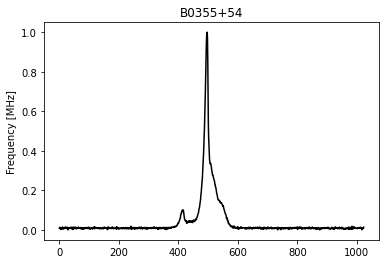

In [49]:
#fig = plt.figure(figsize=(5, 15))  # Set figure size directly in the figure call

#Plot the normalized data
plt.plot(data11[0], "k")


plt.title('B0355+54')
#plt.xlabel('Pulse Phase [bins]')
plt.ylabel('Frequency [MHz]')
plt.show()

### Run the code

In [50]:
def iterate_fit(data, smooth = False):
    data = data[0]
    smooth = False
    resids = []
    resids_percent = False
    iteration = 1
    param_arr = []
    resids_params = []
    mean_baseline = False
    show_all = True
    #Iterate through fitting code while adding a gaussian every time until residuals are less than 5%
    while resids_percent == False:
                   
        print('Iteration #' + str(iteration))
        resids, param_arr, fit_arr, on_pulse, off_pulse_rms, x, resids_params, first_cutoff_idx, last_cutoff_idx, pulse_center, \
        force_smooth, chi_squared = gauss_fit(data, iteration, param_arr, resids_params, mean_baseline, smooth)
        print('max residual: ' + str(max(np.abs(resids))))
        
        if (force_smooth == True) and (smooth == True) and (iteration == 11):
            print('Unable to create a fit with 10 Gaussians and smoothed profiles.')
            if mean_baseline == False:
                print('Will now average all off-pulse values to their mean value.')
                mean_baseline = True
                iteration = 1
            elif mean_baseline == True:
                print('Tried all options, no fit is possible')
                resids_percent = True
        #If the residuals are smaller than 5% we stop, if they are larger we iterate again
        elif (max(np.abs(resids)) < off_pulse_rms) or ((max(resids)< 0.05) and (min(resids) > -0.05)):
        #elif ((max(resids)< 0.05) and (min(resids) > -0.05)):    
            resids_percent = True
            print("The residuals are less than 5% or less than the off-pulse RMS")
            plotting(iteration, data, x, param_arr, on_pulse, resids, first_cutoff_idx, last_cutoff_idx, pulse_center, chi_squared, \
                     show_all)
        else:
            resids_percent = False
            print("The residuals are more than 5% or more than the off-pulse RMS")
            iteration = iteration + 1
            if force_smooth == True:
                iteration = 1
                smooth = True

    gaussian_added = fit_arr
    
    x_high_res, gaussian_added_high_res = high_res_multicomponent_gaussian(iteration, *param_arr)
    
    fwhm = calculate_10percent(gaussian_added_high_res)
    fwhm_deg = val_to_deg(fwhm, gaussian_added_high_res)
    #fwhm_deg = val_to_deg(fwhm, data)
    #plt.plot(x_high_res, gaussian_added_high_res)
    
    uncertainties = width_uncert(data, x, x_high_res, gaussian_added_high_res, first_cutoff_idx, last_cutoff_idx, param_arr)
    uncert_deg = val_to_deg(uncertainties, data)
    print('fwhm, fwhm_deg, uncert, uncer_deg:')
    print(fwhm, fwhm_deg, uncertainties, uncert_deg)
    return(fwhm, fwhm_deg, uncertainties, uncert_deg)
    #uncert_width = width_uncert(data[k], first_cutoff, last_cutoff)

Iteration #1
chi squared: 1.987
max residual: 0.26031887277252297
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 1.134
max residual: 0.1776818382422154
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 2.012
max residual: 0.12323647245062719
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.262
max residual: 0.07996181708503125
The residuals are more than 5% or more than the off-pulse RMS
Iteration #5
chi squared: 0.224
max residual: 0.05861047235905803
The residuals are more than 5% or more than the off-pulse RMS
Iteration #6
chi squared: 0.221
max residual: 0.045727949311652694
The residuals are less than 5% or less than the off-pulse RMS


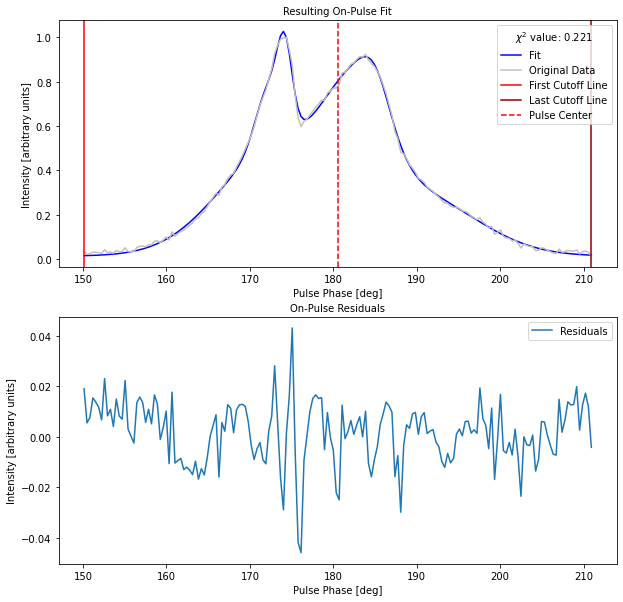

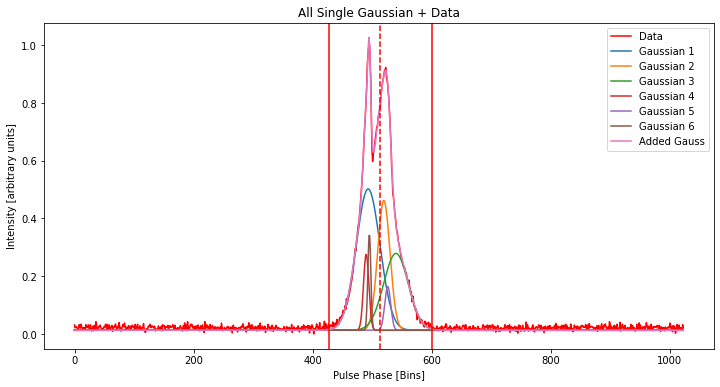

fwhm, fwhm_deg, uncert, uncer_deg:
1114 40.104 0.46189754599933897 0.1623858560153926
Number of files processed: 1
Iteration #1
chi squared: 2.446
max residual: 0.29722006103397147
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 0.917
max residual: 0.15476605327083626
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 1.546
max residual: 0.10140834848111419
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.197
max residual: 0.07471642438109527
The residuals are more than 5% or more than the off-pulse RMS
Iteration #5
chi squared: 0.165
max residual: 0.05151116231867936
The residuals are more than 5% or more than the off-pulse RMS
Iteration #6
chi squared: 0.153
max residual: 0.03609022685349217
The residuals are less than 5% or less than the off-pulse RMS


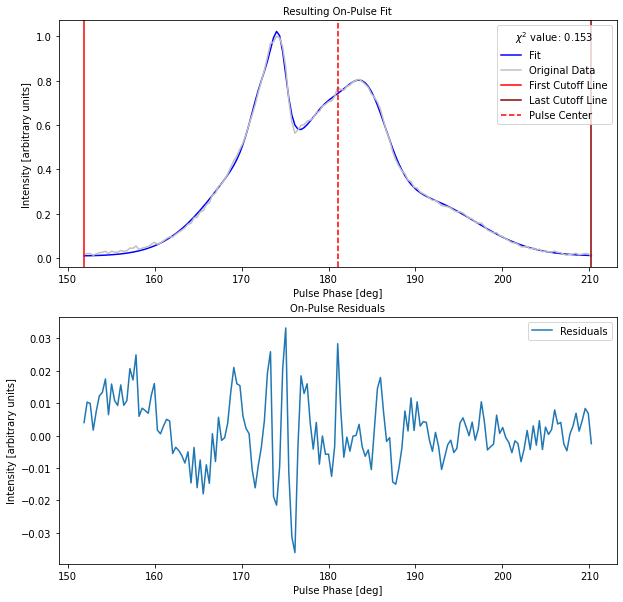

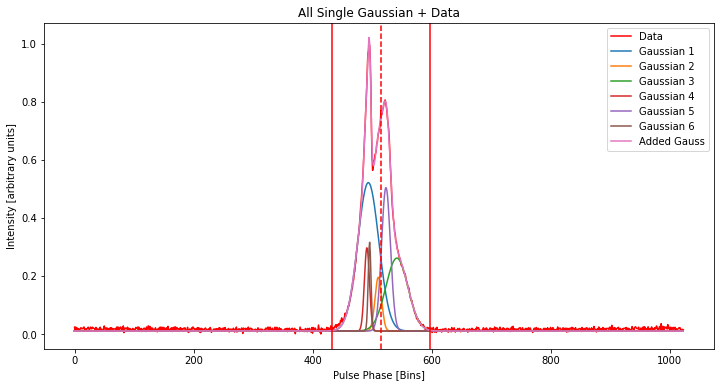

fwhm, fwhm_deg, uncert, uncer_deg:
1045 37.62 0.14833010489586013 0.052147302502450824
Number of files processed: 2
Iteration #1
chi squared: 2.796
max residual: 0.32239903892845423
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 0.758
max residual: 0.12237003348699449
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 0.645
max residual: 0.1259769213997386
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.341
max residual: 0.07732112848335149
The residuals are more than 5% or more than the off-pulse RMS
Iteration #5
chi squared: 0.322
max residual: 0.07018712689210016
The residuals are more than 5% or more than the off-pulse RMS
Iteration #6
chi squared: 0.175
max residual: 0.042201900286953586
The residuals are less than 5% or less than the off-pulse RMS


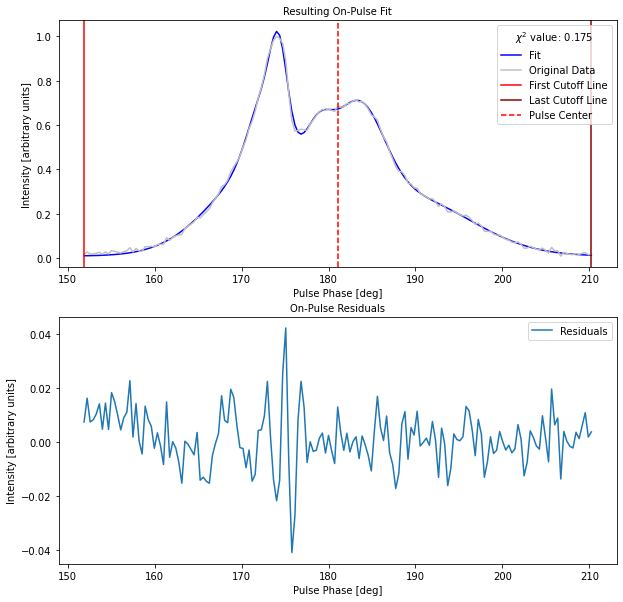

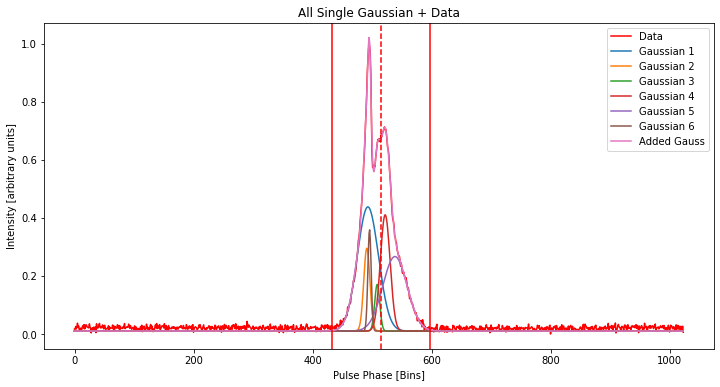

fwhm, fwhm_deg, uncert, uncer_deg:
1035 37.26 0.4016049657856342 0.141189245784012
Number of files processed: 3
Iteration #1
chi squared: 3.694
max residual: 0.3670889187642068
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 0.908
max residual: 0.12012802922770871
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 0.679
max residual: 0.12408615832370351
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.354
max residual: 0.06612849243446584
The residuals are more than 5% or more than the off-pulse RMS
Iteration #5
chi squared: 0.393
max residual: 0.0485842287708107
The residuals are less than 5% or less than the off-pulse RMS


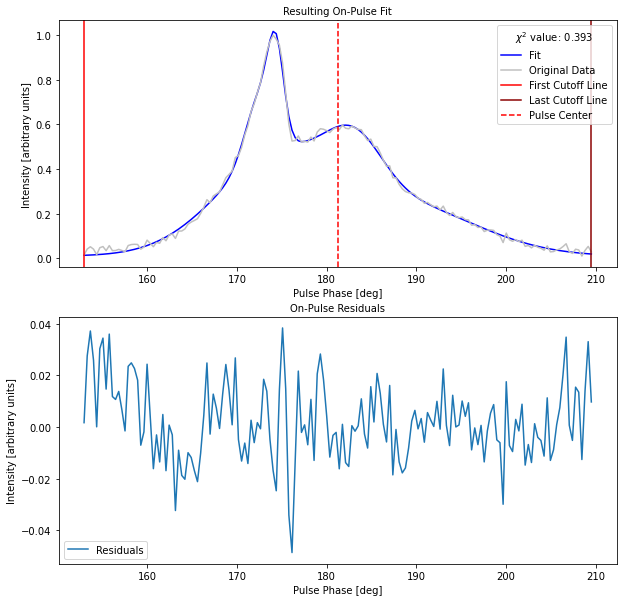

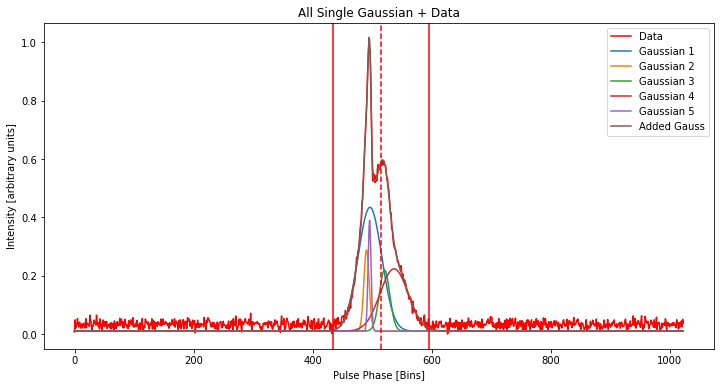

fwhm, fwhm_deg, uncert, uncer_deg:
1034 37.224000000000004 0.2915589746358169 0.10250120202040439
Number of files processed: 4
Iteration #1
chi squared: 4.858
max residual: 0.3610436867898932
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 0.687
max residual: 0.10357098804248421
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 0.304
max residual: 0.050404601798535564
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.156
max residual: 0.04690556139620439
The residuals are less than 5% or less than the off-pulse RMS


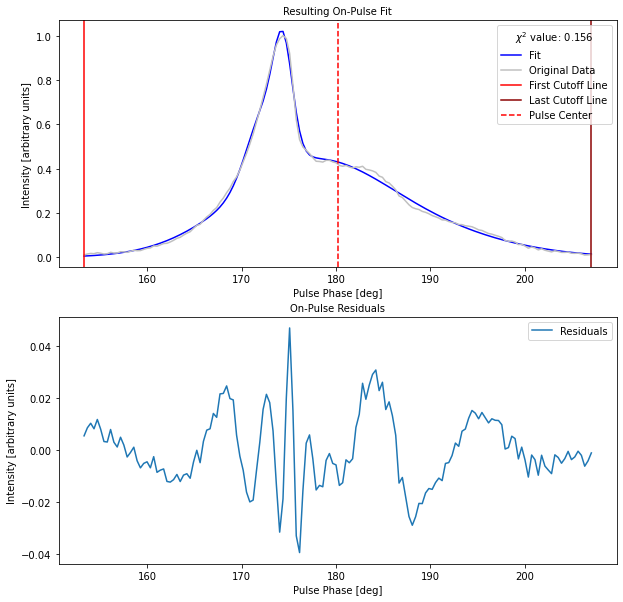

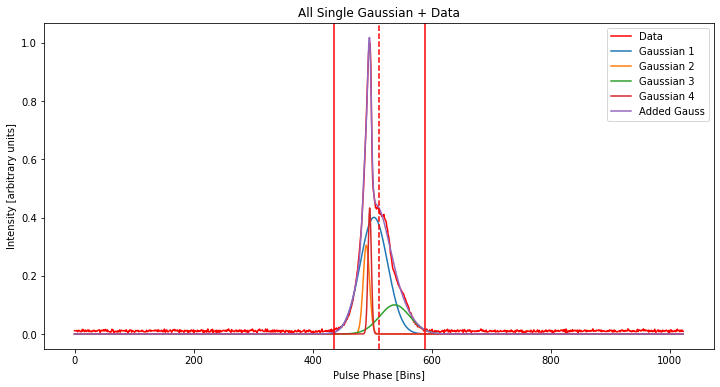

fwhm, fwhm_deg, uncert, uncer_deg:
897 32.292 0.2981704224223133 0.10482553913284451
Number of files processed: 5
Iteration #1
chi squared: 5.33
max residual: 0.3655913164749106
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 0.801
max residual: 0.10971254457751933
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 0.434
max residual: 0.05249350771261463
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.191
max residual: 0.04606957916474186
The residuals are less than 5% or less than the off-pulse RMS


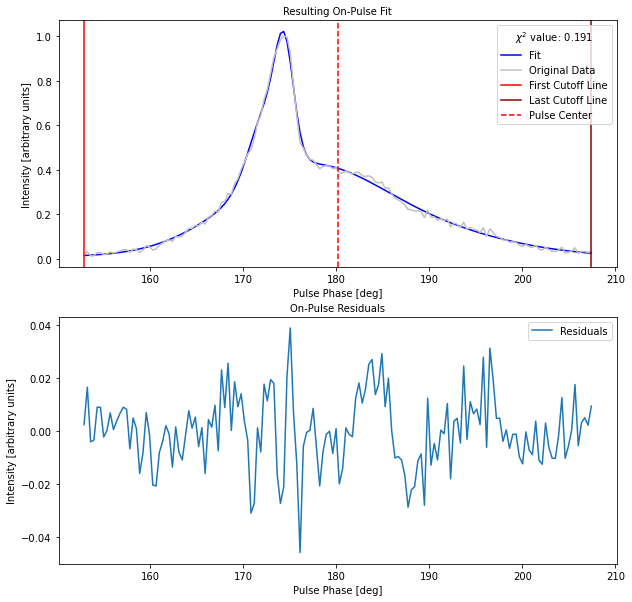

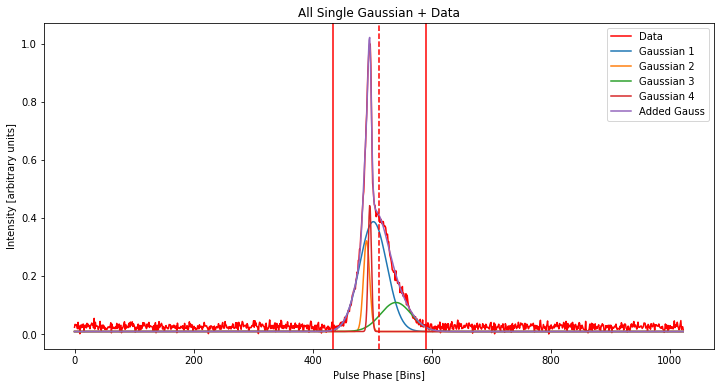

fwhm, fwhm_deg, uncert, uncer_deg:
931 33.516 0.29989400798481475 0.10543148718216143
Number of files processed: 6
Iteration #1
chi squared: 5.729
max residual: 0.3369876331044963
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 0.97
max residual: 0.1045935168677391
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 0.353
max residual: 0.055219390382975075
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.131
max residual: 0.0476564694502184
The residuals are less than 5% or less than the off-pulse RMS


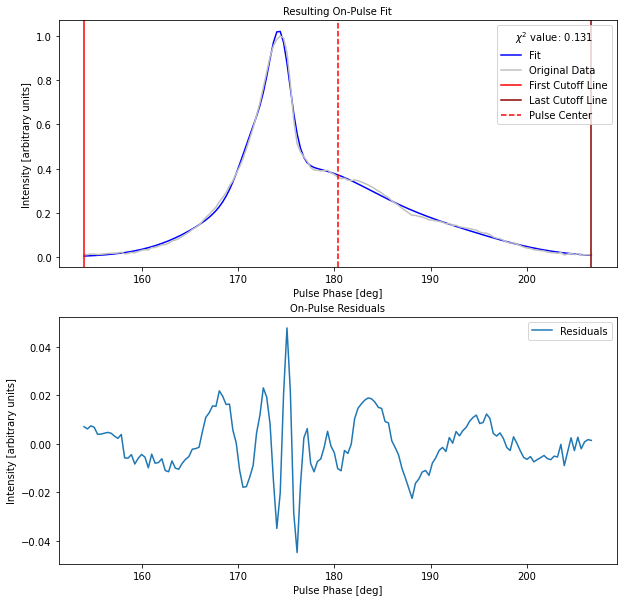

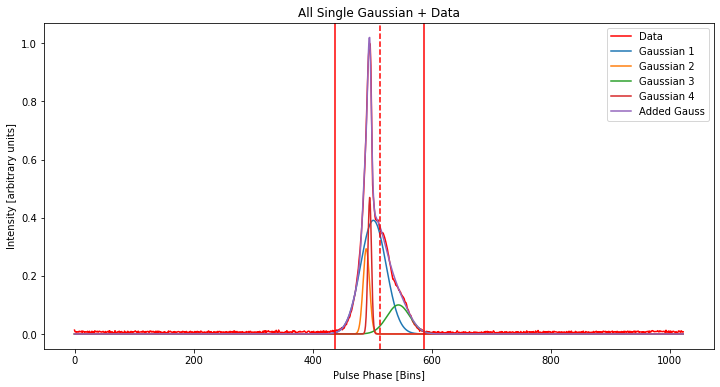

fwhm, fwhm_deg, uncert, uncer_deg:
864 31.104000000000003 0.271920161935278 0.09559693193037118
Number of files processed: 7
Iteration #1
chi squared: 6.002
max residual: 0.32066080472599656
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 0.929
max residual: 0.10964778723748969
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 0.298
max residual: 0.05786392165812493
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.117
max residual: 0.0506062638552478
The residuals are more than 5% or more than the off-pulse RMS
Iteration #5
chi squared: 0.046
max residual: 0.029083717777249607
The residuals are less than 5% or less than the off-pulse RMS


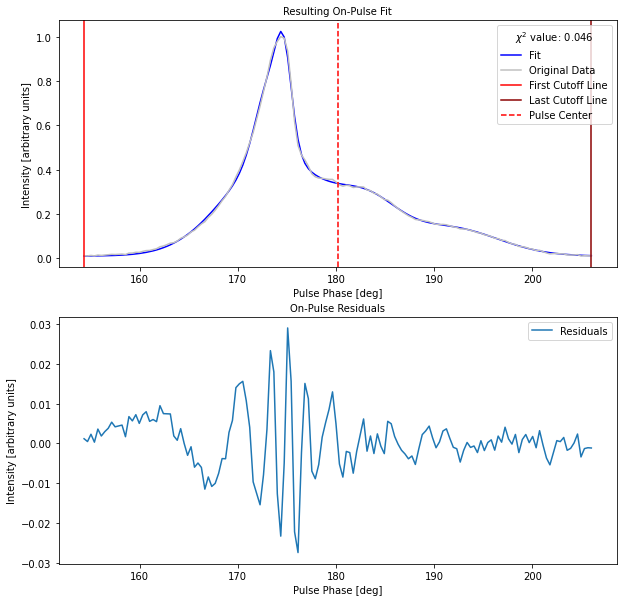

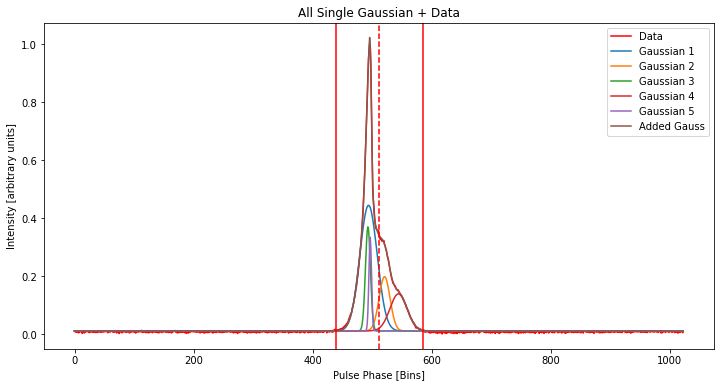

fwhm, fwhm_deg, uncert, uncer_deg:
857 30.852 0.06394902230089985 0.022482078152660106
Number of files processed: 8
Iteration #1
chi squared: 7.071
max residual: 0.2618741392211662
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 0.639
max residual: 0.11332114057308473
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 0.282
max residual: 0.05310374515540228
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.272
max residual: 0.0397487364314828
The residuals are less than 5% or less than the off-pulse RMS


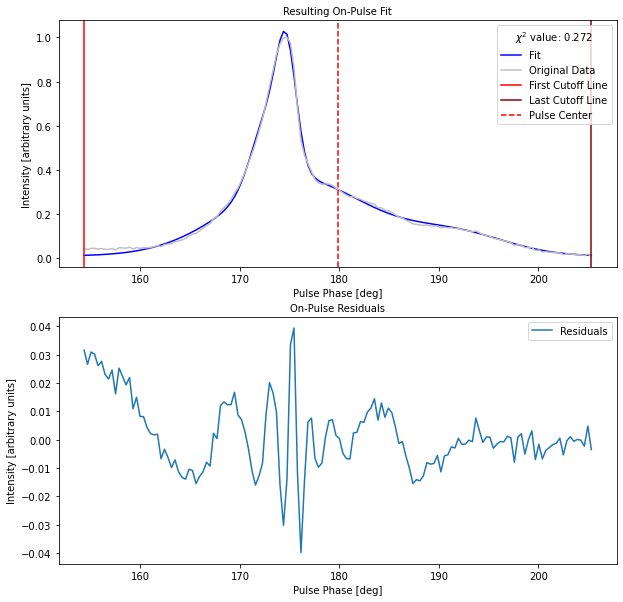

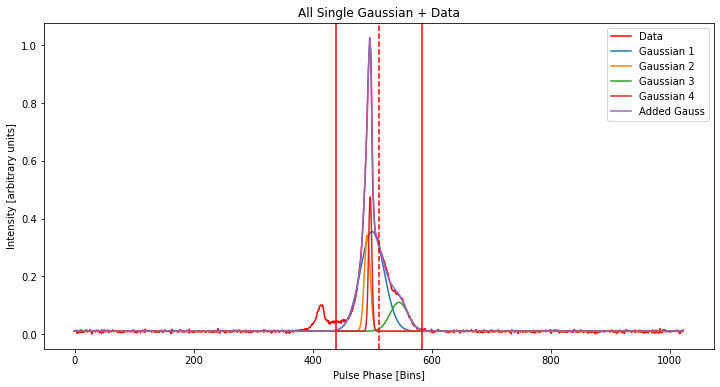

fwhm, fwhm_deg, uncert, uncer_deg:
841 30.275999999999996 0.2556754172941092 0.08988588889246027
Number of files processed: 9
Iteration #1
chi squared: 6.715
max residual: 0.27381759362178015
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 0.605
max residual: 0.11737520389391964
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 0.193
max residual: 0.05655451341981854
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.09
max residual: 0.03949146475002707
The residuals are less than 5% or less than the off-pulse RMS


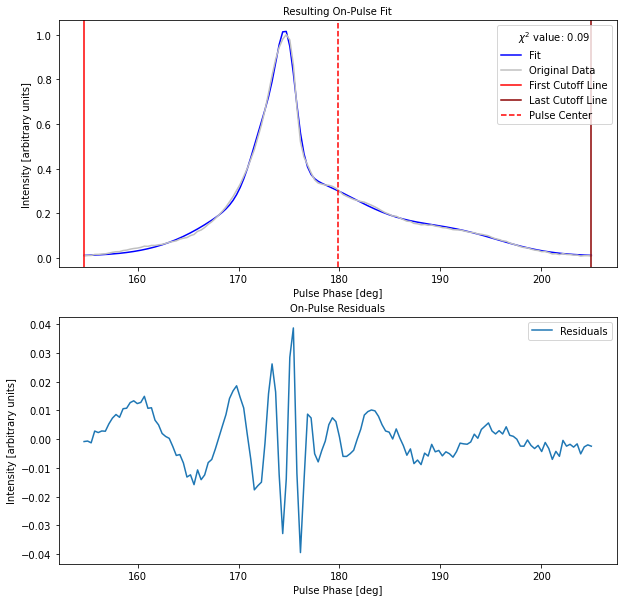

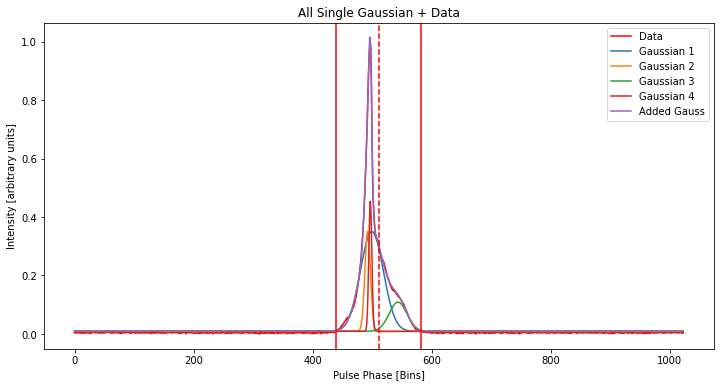

fwhm, fwhm_deg, uncert, uncer_deg:
817 29.412 0.24243500998077003 0.08523105819636446
Number of files processed: 10
Iteration #1
chi squared: 6.763
max residual: 0.2577319443446271
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 0.88
max residual: 0.11921507193019609
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 0.225
max residual: 0.05955879400564601
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.047
max residual: 0.04112556349374841
The residuals are less than 5% or less than the off-pulse RMS


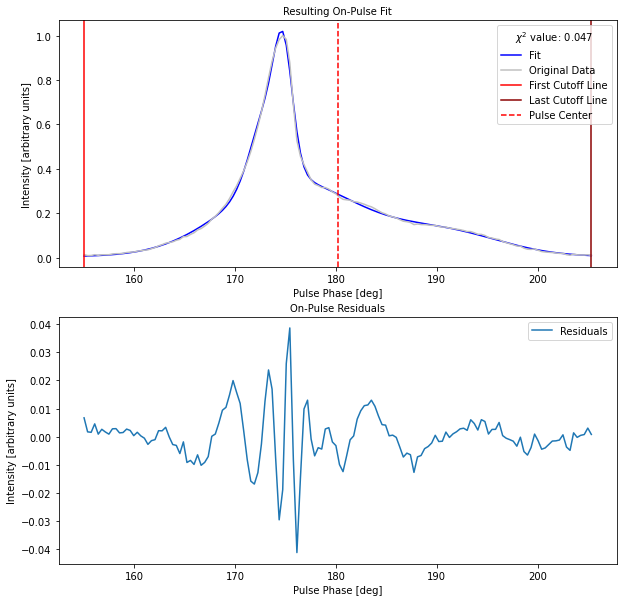

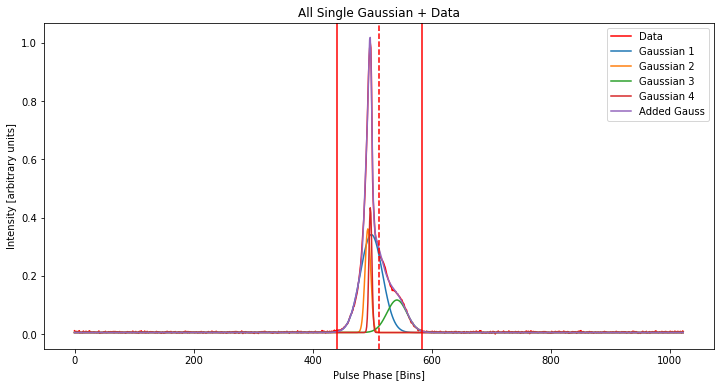

fwhm, fwhm_deg, uncert, uncer_deg:
806 29.016000000000002 0.22991209570896728 0.08082847114768381
Number of files processed: 11
Iteration #1
chi squared: 6.624
max residual: 0.26581608310684723
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 1.374
max residual: 0.12652047281022827
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 0.247
max residual: 0.06429893821962418
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.09
max residual: 0.03179179831027701
The residuals are less than 5% or less than the off-pulse RMS


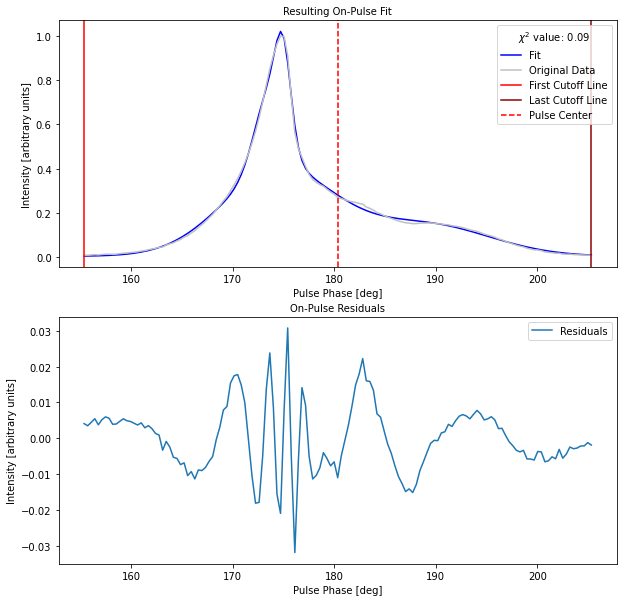

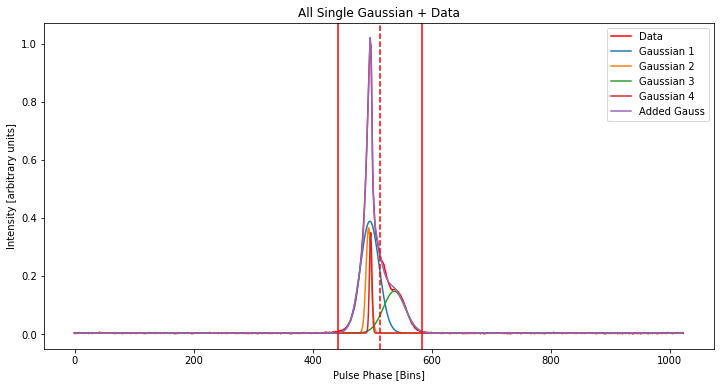

fwhm, fwhm_deg, uncert, uncer_deg:
808 29.087999999999997 0.05714615904396927 0.020090446538895447
Number of files processed: 12
Iteration #1
chi squared: 6.848
max residual: 0.23032851859866976
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 1.308
max residual: 0.1264555655054127
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 0.299
max residual: 0.06009509986519346
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.074
max residual: 0.046031545997257006
The residuals are less than 5% or less than the off-pulse RMS


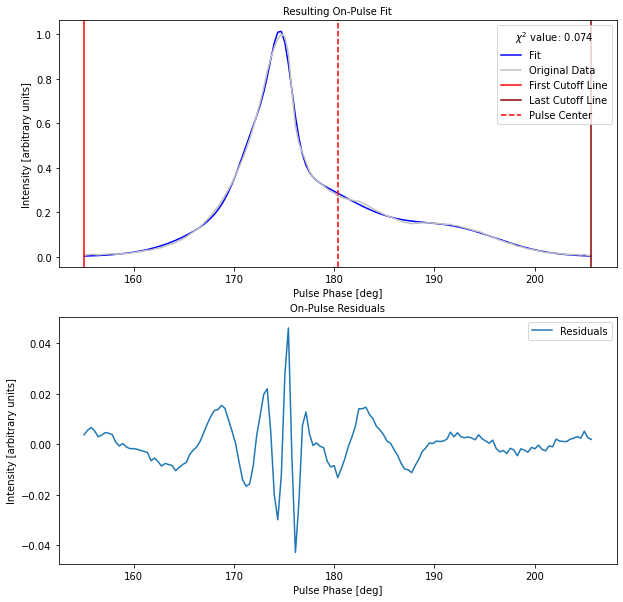

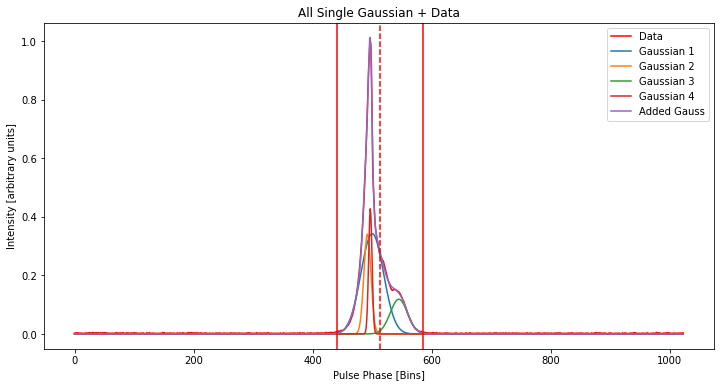

fwhm, fwhm_deg, uncert, uncer_deg:
819 29.484 0.24250568418928414 0.08525590459779521
Number of files processed: 13
Iteration #1
chi squared: 6.037
max residual: 0.23014901305792046
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 1.023
max residual: 0.11598399899097833
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 0.16
max residual: 0.06460281098979404
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.059
max residual: 0.031937285309396546
The residuals are less than 5% or less than the off-pulse RMS


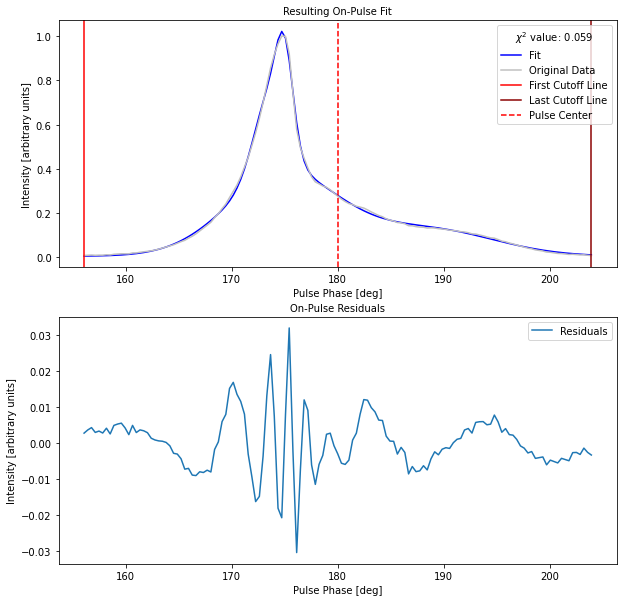

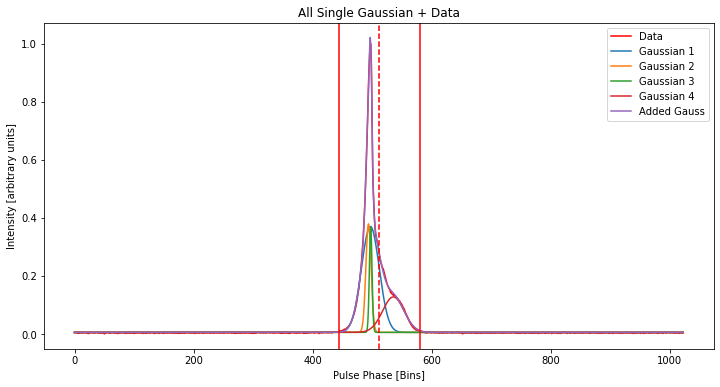

fwhm, fwhm_deg, uncert, uncer_deg:
740 26.639999999999997 0.05808372192695451 0.020420058489944944
Number of files processed: 14
Iteration #1
chi squared: 5.894
max residual: 0.23658611706500443
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 1.093
max residual: 0.11318712348246773
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 0.151
max residual: 0.06986581886930265
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.057
max residual: 0.02865302932378533
The residuals are less than 5% or less than the off-pulse RMS


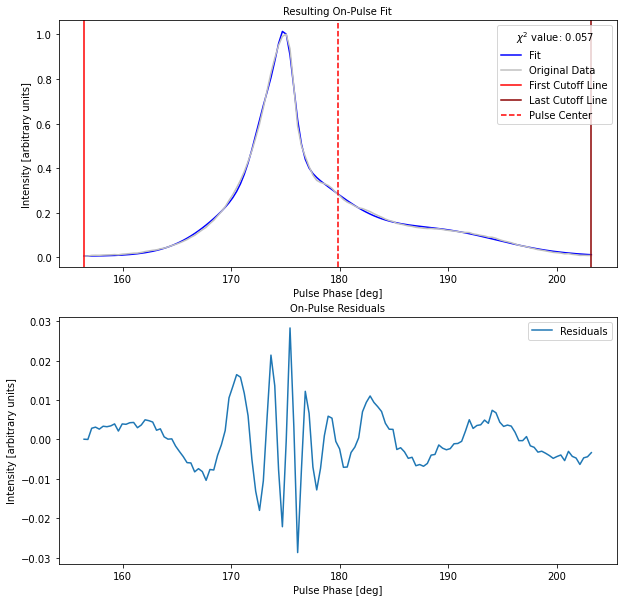

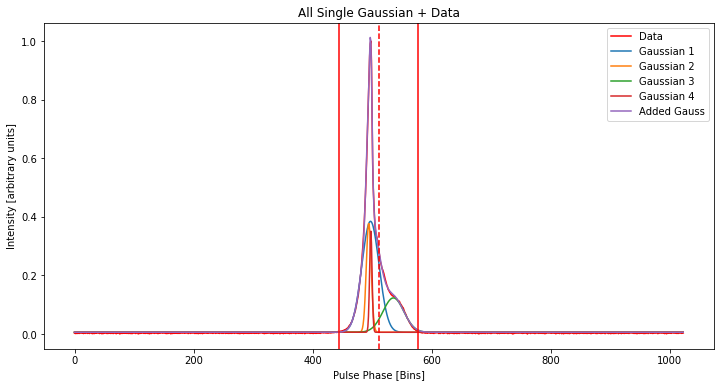

fwhm, fwhm_deg, uncert, uncer_deg:
721 25.956 0.05362580348581347 0.018852821537981297
Number of files processed: 15
Iteration #1
chi squared: 5.625
max residual: 0.23891563952701633
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 1.076
max residual: 0.11349757282272188
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 0.139
max residual: 0.07166553802591324
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.051
max residual: 0.0277505166075922
The residuals are less than 5% or less than the off-pulse RMS


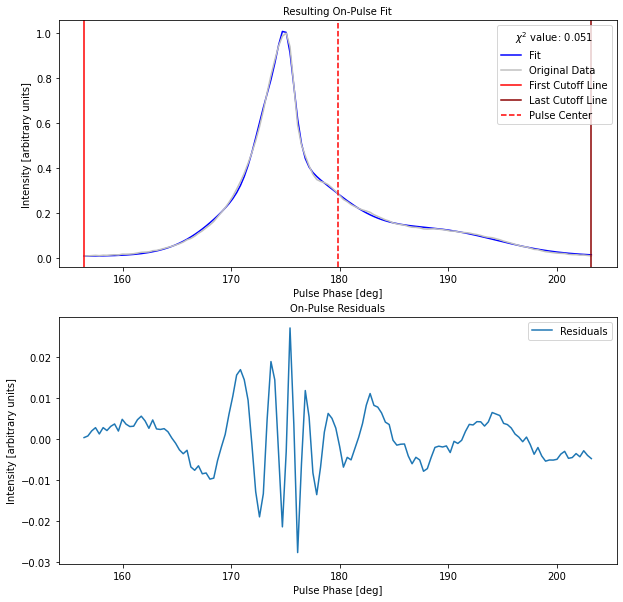

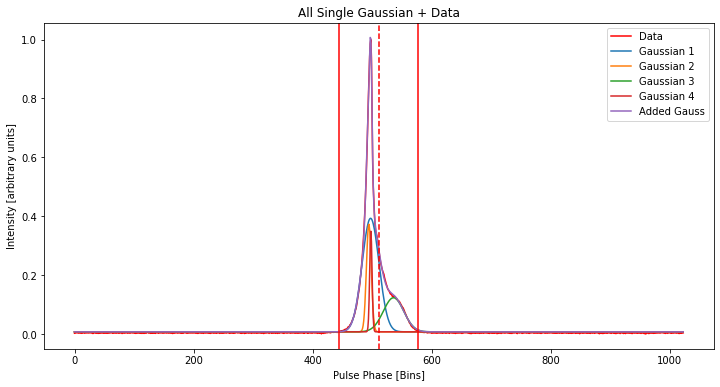

fwhm, fwhm_deg, uncert, uncer_deg:
718 25.848000000000003 0.05280626450372416 0.018564702364590523
Number of files processed: 16
Iteration #1
chi squared: 5.486
max residual: 0.23915248135393663
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 1.115
max residual: 0.11545321550613363
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 0.133
max residual: 0.07155574328904124
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.05
max residual: 0.026959533625281584
The residuals are less than 5% or less than the off-pulse RMS


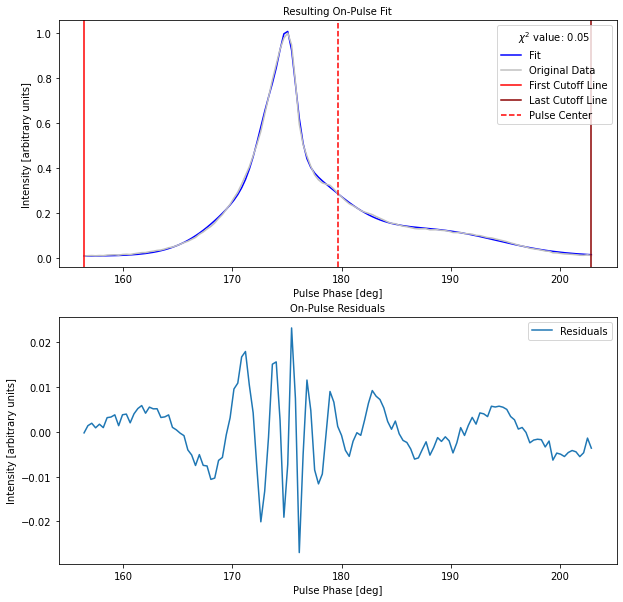

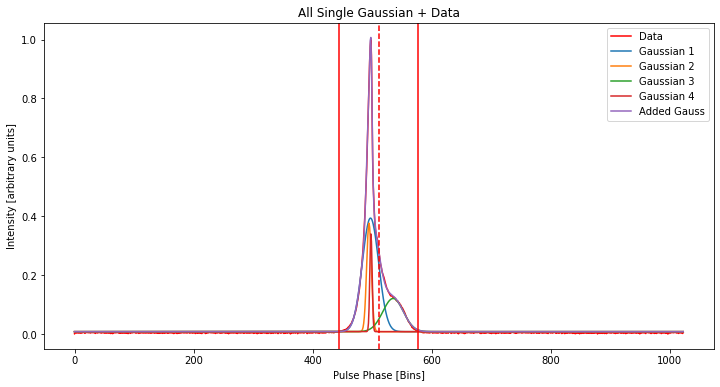

fwhm, fwhm_deg, uncert, uncer_deg:
703 25.308 0.05090832725785486 0.0178974588015896
Number of files processed: 17
Iteration #1
chi squared: 5.224
max residual: 0.23315863283615212
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 1.054
max residual: 0.11895505232737569
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 0.136
max residual: 0.07043514338044987
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.051
max residual: 0.030356151390494635
The residuals are less than 5% or less than the off-pulse RMS


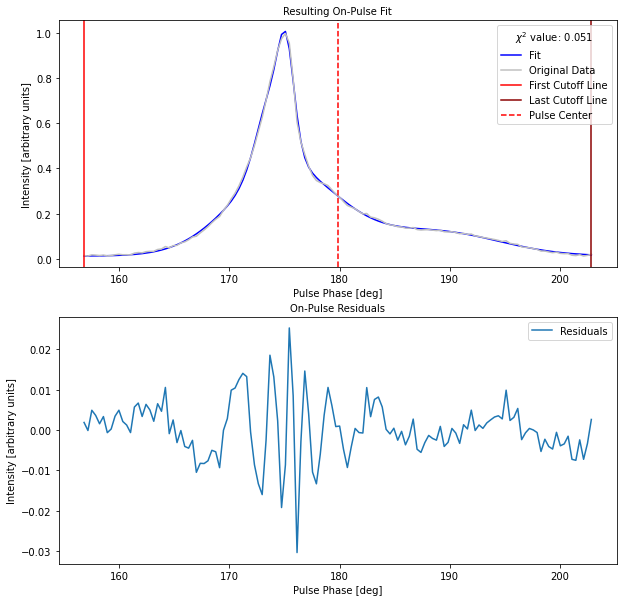

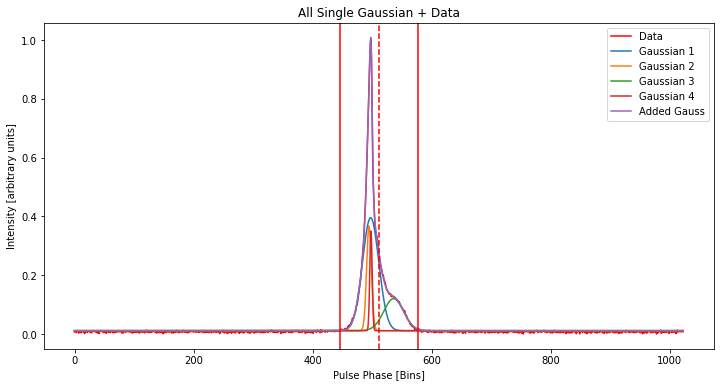

fwhm, fwhm_deg, uncert, uncer_deg:
709 25.524 0.052777972076704954 0.018554755808216587
Number of files processed: 18
Iteration #1
chi squared: 5.791
max residual: 0.2399472626280954
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 0.786
max residual: 0.12624921728710825
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 0.205
max residual: 0.07753992153440714
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.231
max residual: 0.03135452681554811
The residuals are less than 5% or less than the off-pulse RMS


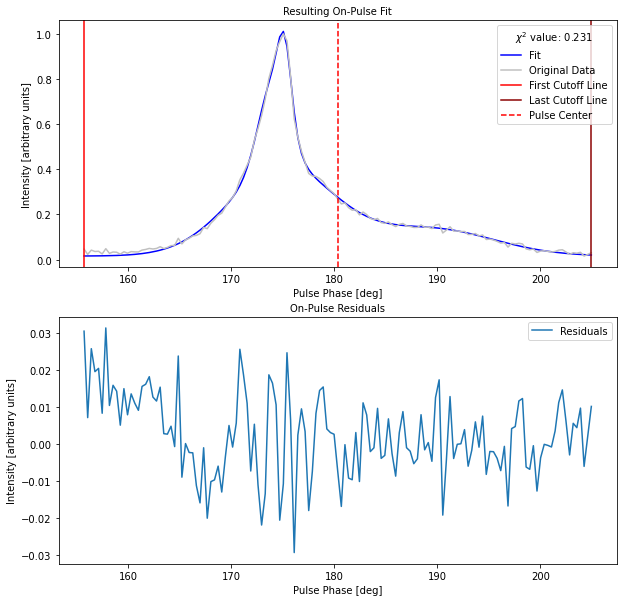

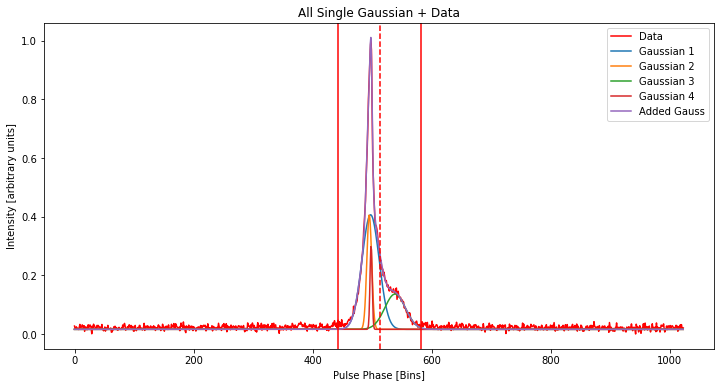

fwhm, fwhm_deg, uncert, uncer_deg:
789 28.404 0.052615470251383537 0.018497626260252024
Number of files processed: 19
Iteration #1
chi squared: 5.737
max residual: 0.2388921583404695
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 0.913
max residual: 0.13025497839923017
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 0.213
max residual: 0.08400196055211617
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.218
max residual: 0.03520892803866005
The residuals are less than 5% or less than the off-pulse RMS


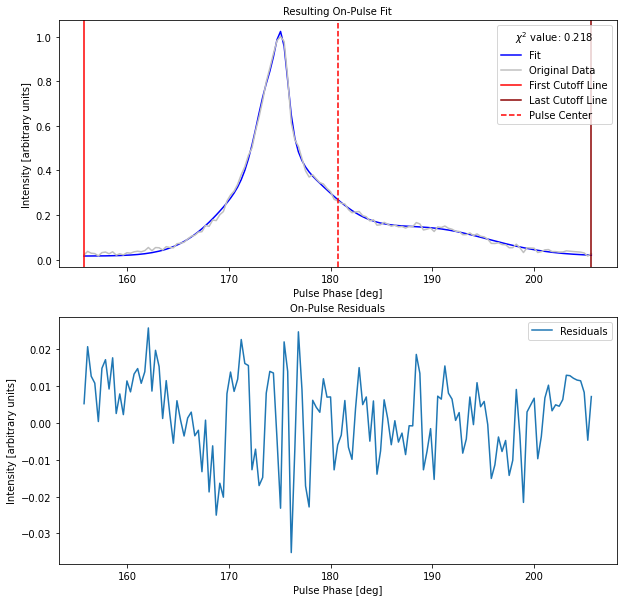

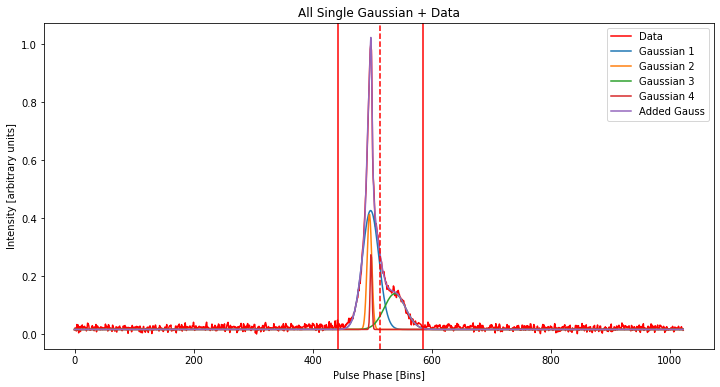

fwhm, fwhm_deg, uncert, uncer_deg:
785 28.26 0.049514789728084964 0.01740754326377987
Number of files processed: 20
Iteration #1
chi squared: 5.754
max residual: 0.24767277352568107
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 0.83
max residual: 0.11407371598294025
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 0.202
max residual: 0.06607762246381954
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.253
max residual: 0.031984888800577774
The residuals are less than 5% or less than the off-pulse RMS


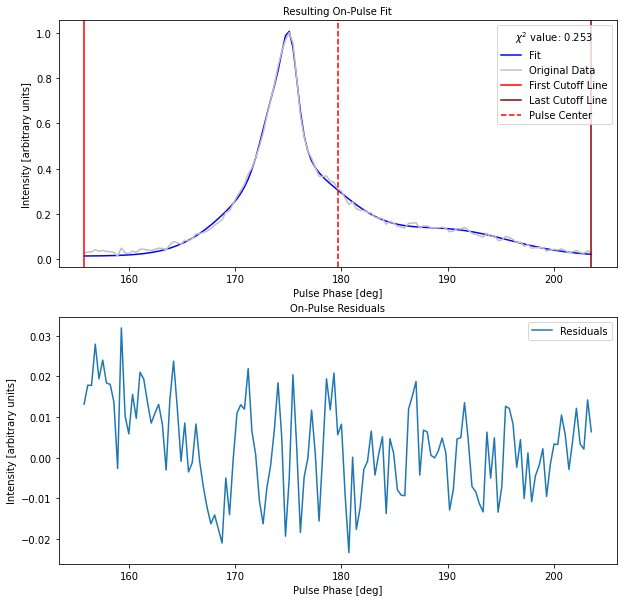

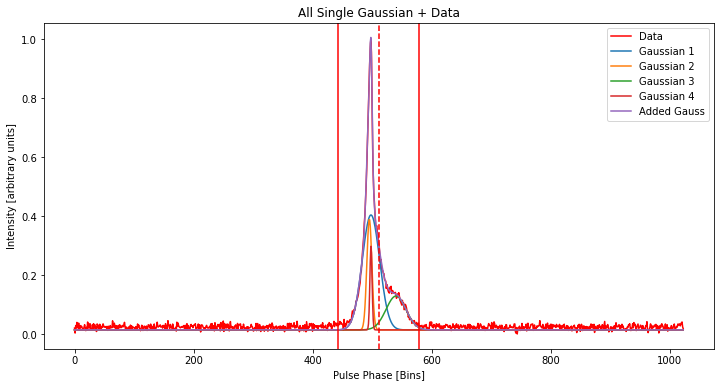

fwhm, fwhm_deg, uncert, uncer_deg:
782 28.152 0.05289513874638492 0.01859594721552595
Number of files processed: 21
Iteration #1
chi squared: 4.504
max residual: 0.22632270458486736
The residuals are more than 5% or more than the off-pulse RMS
Iteration #2
chi squared: 0.797
max residual: 0.13000651222261073
The residuals are more than 5% or more than the off-pulse RMS
Iteration #3
chi squared: 0.152
max residual: 0.07816941519459453
The residuals are more than 5% or more than the off-pulse RMS
Iteration #4
chi squared: 0.11
max residual: 0.02783592154414616
The residuals are less than 5% or less than the off-pulse RMS


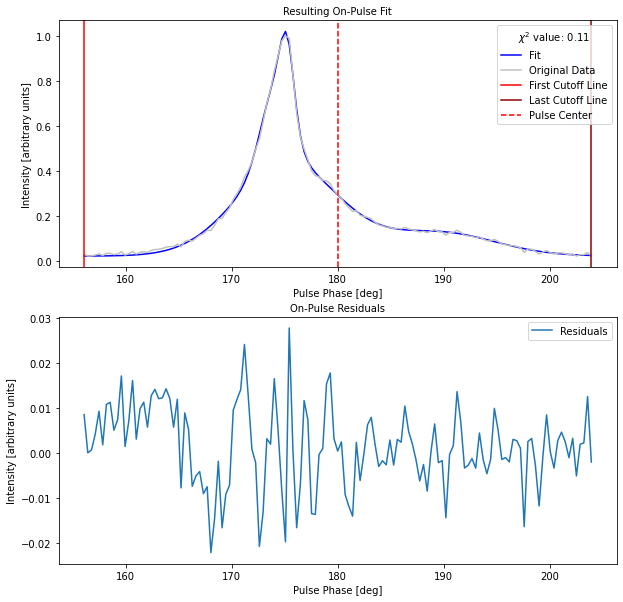

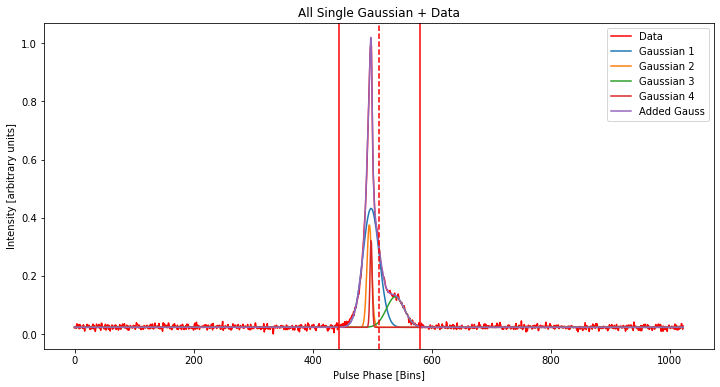

fwhm, fwhm_deg, uncert, uncer_deg:
753 27.108 0.05382955715690337 0.018924453687973842
Number of files processed: 22


In [51]:
fwhm_arr = []
fwhm_arr_deg = []
fwhm_err = []
fwhm_err_deg = []
counter = 0  # Initialize counter variable

for file in data_list:
    
    fwhm, fwhm_deg, uncertainties, uncert_deg = iterate_fit(file)
    fwhm_arr = np.append(fwhm_arr, fwhm)
    fwhm_arr_deg = np.append(fwhm_arr_deg, fwhm_deg)
    fwhm_err = np.append(fwhm_err, uncertainties)
    fwhm_err_deg = np.append(fwhm_err_deg, uncert_deg)
    counter += 1 # Increment the counter
    print("Number of files processed: " + str(counter))

In [52]:
print('fwhm_arr: ')
print(fwhm_arr)

print('fwhm_err')
print(fwhm_err)

fwhm_arr: 
[1114. 1045. 1035. 1034.  897.  931.  864.  857.  841.  817.  806.  808.
  819.  740.  721.  718.  703.  709.  789.  785.  782.  753.]
fwhm_err
[0.46189755 0.1483301  0.40160497 0.29155897 0.29817042 0.29989401
 0.27192016 0.06394902 0.25567542 0.24243501 0.2299121  0.05714616
 0.24250568 0.05808372 0.0536258  0.05280626 0.05090833 0.05277797
 0.05261547 0.04951479 0.05289514 0.05382956]


[0.46189755 0.1483301  0.40160497 0.29155897 0.29817042 0.29989401
 0.27192016 0.06394902 0.25567542 0.24243501 0.2299121  0.05714616
 0.24250568 0.05808372 0.0536258  0.05280626 0.05090833 0.05277797
 0.05261547 0.04951479 0.05289514 0.05382956]


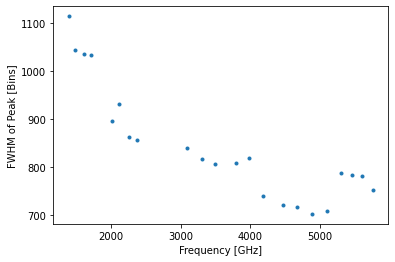

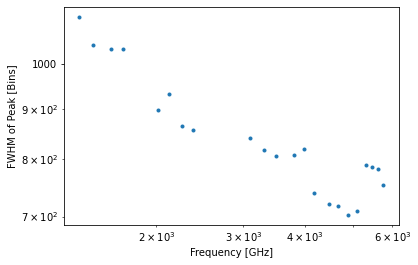

In [53]:
#x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#fwhm_arr = [51, 15,  14, 13, 13, 14, 14, 14, 12, 12]
#fwhm_err = [16.931253285138236, 23.679996956108205, 27.776422080908258, 24.742653109168327, 29.113171257276516, 41.83598087314122, 21.79203051769033, 32.74530354042601, 23.73581282530642, 21.773117178246384]
#Freq chn 4 is not in a realistic freq range
#x = [1, 2, 3, 4, 5, 6, 7, 8, 9]
#fwhm_arr = [51, 15,  14, 13, 14, 14, 14, 12, 12]
#fwhm_err = [16.931253285138236, 23.679996956108205, 27.776422080908258, 29.113171257276516, 41.83598087314122, 21.79203051769033, 32.74530354042601, 23.73581282530642, 21.773117178246384]
#Calculate with uncertainties given by curve_fit instead of width_uncert:
x = [1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
#fwhm_arr = [0.25410350821928307, 0, 1.6134841384536582, 8.54995325440967, 0, 2.840984193080027, 7.104977305835612, 0.6979999658531637, 0.33348667888155686, 0]
#x = [1, 2, 3, 4, 5, 6, 7, 8]
#fwhm_arr = [15,  13, 14, 14, 13, 15, 12, 12]
#fwhm_err = [14.672847031937257, 18.666736896283183, 13.957855402000883, 17.010523864455322, 12.969257900014515, 12.635494181504848, 19.142833942259355, 12.30583707996548]
print(fwhm_err)
plt.errorbar(freqs, fwhm_arr, yerr=fwhm_err, fmt='.')
plt.xlabel('Frequency [GHz]')
plt.ylabel('FWHM of Peak [Bins]')
plt.show()
plt.close()
plt.figure()
plt.errorbar(freqs, fwhm_arr, yerr=fwhm_err, fmt='.')
plt.xlabel('Frequency [GHz]')
plt.ylabel('FWHM of Peak [Bins]')
plt.xscale('log')
plt.yscale('log')
ax = plt.gca()
# Set tick formatter
# Set tick formatter
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())
plt.show()
plt.close()

In [54]:
#x = [1.57, 2.00, 2.43, 2.86, 3.29, 3.72, 4.15, 4.58, 5.01, 5.44]
#fwhm_arr_deg = [17.9296875, 5.2734375, 4.5703125, 4.5703125, 4.921875, 4.921875, 4.5703125, 5.2734375, 4.21875, 4.21875]
#fwhm_err_deg = [4.985099891163588, 5.158422784665442, 6.562524690099557, 9.750545739790965, 4.907058539765935, 5.980262296097575, 4.559504730473853,\
#4.442165923185298, 6.729902557825555, 4.326270848425364 ]
#Include the 1st but exclude #4 since it is not in a real freq
#x = [1.57, 2.00, 2.43, 3.29, 3.72, 4.15, 4.58, 5.01, 5.44]
#fwhm_arr_deg = [17.9296875, 5.2734375, 4.921875, 4.570312, 4.921875, 4.921875, 4.921875, 4.21875, 4.21875]
#fwhm_err_deg = [5.952393733056411, 8.32499892988179, 9.765148387819309, 10.235099270136276, 14.707962025713709, 7.661260728875506, \
#                11.512020775931019, 8.34462169639679, 7.654611507977244]
#x = [2.00, 2.43, 3.29, 3.72, 4.15, 4.58, 5.01, 5.44]
#fwhm_arr_deg = [5.2734375, 4.5703125, 4.921875, 4.921875, 4.5703125, 5.2734375, 4.21875, 4.21875]
#fwhm_err_deg = [ 5.158422784665442, 6.562524690099557, 4.907058539765935, 5.980262296097575, 4.559504730473853, \
#                4.442165923185298, 6.729902557825555, 4.326270848425364 ]
fwhm_arr_rads = [degrees_to_radians(deg) for deg in fwhm_arr_deg]
fwhm_err_rads = [degrees_to_radians(deg) for deg in fwhm_err_deg]

In [55]:
# Define power law function
def power_law_fit(x, a, b):
    return a * np.power(x, b)

In [56]:
def fit_power_law(x, y, alpha):
    # Ensure x and y are NumPy arrays
    x = np.array(x)
    y = np.array(y)

    # Define the power law function
    def power_law(x, A):
        return A * x**alpha

    # Fit the power law function to the data
    popt, _ = curve_fit(power_law, x, y)

    # Extract the scaling constant
    A = popt[0]

    # Return the fitted scaling constant as a float
    return A

In [57]:
print(fwhm_arr_deg)
print(fwhm_err_deg)
widths_with_uncertainties = unp.uarray(fwhm_arr_rads, fwhm_err_rads)
widths_with_uncertainties_deg = unp.uarray(fwhm_arr_deg, fwhm_err_deg)

[40.104 37.62  37.26  37.224 32.292 33.516 31.104 30.852 30.276 29.412
 29.016 29.088 29.484 26.64  25.956 25.848 25.308 25.524 28.404 28.26
 28.152 27.108]
[0.16238586 0.0521473  0.14118925 0.1025012  0.10482554 0.10543149
 0.09559693 0.02248208 0.08988589 0.08523106 0.08082847 0.02009045
 0.0852559  0.02042006 0.01885282 0.0185647  0.01789746 0.01855476
 0.01849763 0.01740754 0.01859595 0.01892445]


1394.725
3
constant 4: 2430.379377653735
Fit power index: -0.2757881725594975


Text(0, 0.5, 'FWHM of Peak [Degrees]')

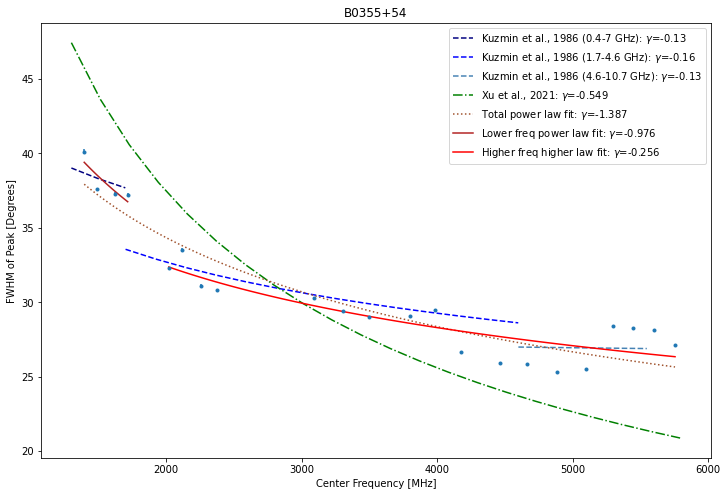

In [58]:
x_power_law1 = np.arange(1300,1700,199)
power_law1 = x_power_law1**(-0.13)
x_power_law2 = np.arange(1700,4600, 223)
power_law2 = x_power_law2**(-0.16)
x_power_law3 = np.arange(4600,5700, 158)
power_law3 = x_power_law3**(-0.02)
print(freqs[0])
print(len(x_power_law1))
#print(len(fwhm_arr_deg[7:10]))
constant1 = fit_power_law(x_power_law1, fwhm_arr_deg[0:3], -0.13)
constant2 = fit_power_law(x_power_law2, fwhm_arr_deg[2:16], -0.16)
constant3 = fit_power_law(x_power_law3, fwhm_arr_deg[15:22], -0.02)

#Power law from the Xu et al. paper:
x_power_law4 = np.arange(1300,6000,214)
power_law4 = x_power_law4**(-0.549)
constant4 = fit_power_law(x_power_law4, fwhm_arr_deg, -0.549)
print('constant 4: ' +str(constant4))
# Known exponent value
#exponent_value = -0.549
# Perform curve fitting
#print('min: ' + str(min(fwhm_arr_deg)))
#popt, pcov = curve_fit(power_law_fit, freqs, fwhm_arr_deg, p0=(600.0, exponent_value))
# Retrieve constant value
#constant_value = popt[0]
#print('constant value: ' +str(constant_value))

#Now we want to make our own fit on the data:
# Fit the power law function to the data
params, covariance = curve_fit(power_law_fit, freqs, fwhm_arr_deg)
# Extract the parameters
a_fit, b_fit = params
# Plot fitted power law
x_fit = np.linspace(min(freqs), max(freqs), 100)
y_fit = power_law_fit(x_fit, a_fit, b_fit)

#We can seperate into two fits:
#Now we want to make our own fit on the data:
# Fit the power law function to the data
params2, covariance2 = curve_fit(power_law_fit, freqs[0:4], fwhm_arr_deg[0:4])
params3, covariance3 = curve_fit(power_law_fit, freqs[4:22], fwhm_arr_deg[4:22])
# Extract the parameters
a_fit2, b_fit2 = params2
a_fit3, b_fit3 = params3
# Plot fitted power law
x_fit2 = np.linspace(min(freqs[0:4]), max(freqs[0:4]), 100)
y_fit2 = power_law_fit(x_fit2, a_fit2, b_fit2)
x_fit3 = np.linspace(min(freqs[4:22]), max(freqs[4:22]), 100)
y_fit3 = power_law_fit(x_fit3, a_fit3, b_fit3)
print('Fit power index: ' + str(b_fit)) #-0.176

#----


mean1 = np.mean(fwhm_arr_deg[0:4])
#mean2 = np.mean(fwhm_arr_deg[7:9])

# Set the figure size
plt.figure(figsize=(12, 8))
plt.errorbar(freqs, fwhm_arr_deg, yerr=fwhm_err_deg, fmt='.')
#plt.axvline(x = 1.40, color = 'r', ls = '--', label = '1.4 GHz')
plt.plot(x_power_law1, constant1*power_law1, color='navy', linestyle='--', label=r'Kuzmin et al., 1986 (0.4-7 GHz): $\gamma$=-0.13')
plt.plot(x_power_law2, constant2*power_law2, color='blue', linestyle='--', label=r'Kuzmin et al., 1986 (1.7-4.6 GHz): $\gamma$=-0.16')#    'Fitted Power Law: x=-0.16')
plt.plot(x_power_law3,  constant3*power_law3,  color='steelblue', linestyle='--', label=r'Kuzmin et al., 1986 (4.6-10.7 GHz): $\gamma$=-0.13')   #'Fitted Power Law:x=-0.13')
plt.plot(x_power_law4,  constant4*power_law4,  color='green', linestyle='-.', label=r'Xu et al., 2021: $\gamma$=-0.549')
plt.plot(x_fit, y_fit, color='sienna', linestyle=':', label='Total power law fit: $\gamma$=-1.387')
plt.plot(x_fit2, y_fit2, color='firebrick', linestyle='-', label='Lower freq power law fit: $\gamma$=-0.976')
plt.plot(x_fit3, y_fit3, color='red', linestyle='-', label='Higher freq higher law fit: $\gamma$=-0.256')
plt.legend(fontsize="10")
plt.title('B0355+54')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Center Frequency [MHz]')
plt.ylabel('FWHM of Peak [Degrees]')

Calculate with uncertaintites on the power laws:

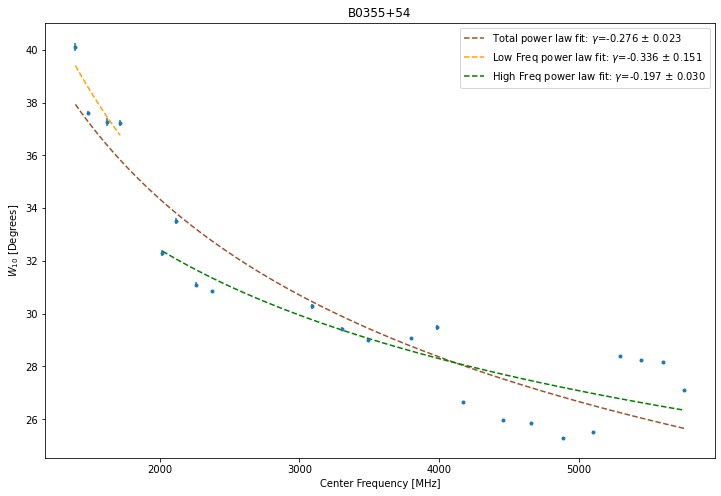

In [59]:
# Convert your data to uncertainty arrays
widths_with_uncertainties_deg = unp.uarray(fwhm_arr_deg, fwhm_err_deg)
freqs_with_uncertainties = unp.uarray(freqs, 0)  # Assume no uncertainties in frequencies for simplicity

# Now perform curve fitting with uncertainties
params, covariance = curve_fit(power_law_fit, unp.nominal_values(freqs_with_uncertainties), unp.nominal_values(widths_with_uncertainties_deg))
params2, covariance2 = curve_fit(power_law_fit, unp.nominal_values(freqs_with_uncertainties[0:4]), unp.nominal_values(widths_with_uncertainties_deg[0:4]))
params3, covariance3 = curve_fit(power_law_fit, unp.nominal_values(freqs_with_uncertainties[4:22]), unp.nominal_values(widths_with_uncertainties_deg[4:22]))

# Extract the parameters with uncertainties
a_fit, b_fit = params
a_fit_err, b_fit_err = np.sqrt(np.diag(covariance))
a_fit2, b_fit2 = params2
a_fit_err2, b_fit_err2 = np.sqrt(np.diag(covariance2))
a_fit3, b_fit3 = params3
a_fit_err3, b_fit_err3 = np.sqrt(np.diag(covariance3))

# Generate fitted curve with uncertainties
x_fit = np.linspace(min(freqs), max(freqs), 100)
y_fit = power_law_fit(x_fit, a_fit, b_fit)
x_fit2 = np.linspace(min(freqs[0:4]), max(freqs[0:4]), 100)
y_fit2 = power_law_fit(x_fit2, a_fit2, b_fit2)
x_fit3 = np.linspace(min(freqs[4:22]), max(freqs[4:22]), 100)
y_fit3 = power_law_fit(x_fit3, a_fit3, b_fit3)


# Plotting
plt.figure(figsize=(12, 8))
plt.errorbar(freqs, fwhm_arr_deg, yerr=fwhm_err_deg, fmt='.')
plt.plot(x_fit, y_fit, color='sienna', linestyle='--', label=f'Total power law fit: $\gamma$={b_fit:.3f} $\pm$ {b_fit_err:.3f}')
plt.plot(x_fit2, y_fit2, color='orange', linestyle='--', label=f'Low Freq power law fit: $\gamma$={b_fit2:.3f} $\pm$ {b_fit_err2:.3f}')
plt.plot(x_fit3, y_fit3, color='green', linestyle='--', label=f'High Freq power law fit: $\gamma$={b_fit3:.3f} $\pm$ {b_fit_err3:.3f}')

plt.legend(fontsize="10")
plt.title('B0355+54')
plt.xlabel('Center Frequency [MHz]')
plt.ylabel('$W_{10}$ [Degrees]')
plt.show()

Emission Height

In [60]:
#Define variables
widths_with_uncertainties = unp.uarray(fwhm_arr_rads, fwhm_err_rads)
widths_with_uncertainties_deg = unp.uarray(fwhm_arr_deg, fwhm_err_deg)
print(widths_with_uncertainties[0])
R = 10000 #meters
c = constants.c #meters/s
pi = constants.pi
print(pi)
P = 0.156384121559 #s
#rho = u.ufloat(17.7, 2.8) 
s = 0.99
alpha = 51 #deg
beta = 4.4 #deg
print(c)
print(widths_with_uncertainties_deg)

0.6999+/-0.0028
3.141592653589793
299792458.0
[40.104+/-0.1623858560153926 37.62+/-0.052147302502450824
 37.26+/-0.141189245784012 37.224000000000004+/-0.10250120202040439
 32.292+/-0.10482553913284451 33.516+/-0.10543148718216143
 31.104000000000003+/-0.09559693193037118 30.852+/-0.022482078152660106
 30.275999999999996+/-0.08988588889246027 29.412+/-0.08523105819636446
 29.016000000000002+/-0.08082847114768381
 29.087999999999997+/-0.020090446538895447 29.484+/-0.08525590459779521
 26.639999999999997+/-0.020420058489944944 25.956+/-0.018852821537981297
 25.848000000000003+/-0.018564702364590523 25.308+/-0.0178974588015896
 25.524+/-0.018554755808216587 28.404+/-0.018497626260252024
 28.26+/-0.01740754326377987 28.152+/-0.01859594721552595
 27.108+/-0.018924453687973842]


In [61]:
#Calculate just from profile
emission_height = (3/2)*((widths_with_uncertainties**2)*(c*P))/(8*pi)

In [62]:
#Calculate from profile and rho
#Convert values to radians because np.cos and unp.cos use radians
alpha_rad = np.deg2rad(alpha)
beta_rad = np.deg2rad(beta)

#Why do these values seem so wrong? Whic equation should we use, I think the first one?
rho = unp.arccos((unp.cos(alpha_rad)*unp.cos(alpha_rad+beta_rad)) + (unp.sin(alpha_rad)*unp.sin(alpha_rad+beta_rad)*unp.cos(widths_with_uncertainties/2)))
#rho = unp.cos(alpha)*unp.cos(alpha+beta) + unp.sin(alpha)*unp.sin(alpha+beta)*unp.cos(widths_with_uncertainties_deg/2)
#rho = unp.arccos(unp.cos(beta) - 2*unp.sin(alpha)*unp.sin(alpha+beta)*(unp.sin(widths_with_uncertainties_deg/4)**2)) #Rankin1993

rho_deg = unp.degrees(rho)
#One of the two following equations is probably right
#emission_height_rho = ((((rho)**2)/86)*((c*P)/(2*pi)))
emission_height_rho = 10*(((rho_deg/1.24)*np.sqrt(P))**2) #Gives a crazy low value
#emission_height_rho = 6.66*(rho**2)*P #Rankin1993

print(emission_height_rho)

[280.5817160411516+/-2.104880463617789
 249.36663341115863+/-0.6346501020641219
 245.0060019224368+/-1.7020912559038128
 244.57221486909742+/-1.2345133907984136
 189.06255956560915+/-1.0969803852021716
 202.1118145751072+/-1.1447136655729298
 176.85690746635095+/-0.9639371509254169
 174.32610557142482+/-0.2248742473394239
 168.6180519318995+/-0.882431091819982
 160.2559893866051+/-0.8130493538778194
 156.50363430371135+/-0.7607515885186505
 157.1821271776738+/-0.18955533310050796
 160.94365690470838+/-0.8152612833130763
 135.04993795676515+/-0.17656211721350598
 129.21117022958686+/-0.15885194631186378
 128.30305475371+/-0.15577743983113204
 123.818930556173+/-0.1470598593112939
 125.60128843133623+/-0.15375418377916186
 150.803817901728+/-0.1704539382319365
 149.48020969428325+/-0.1596017163426976
 148.49188581471495+/-0.16985084238967693
 139.1318089749147+/-0.16648561758150812]


In [63]:
print(emission_height/10000)

[137.0865590783106+/-1.1101594975132734
 120.6304852533708+/-0.33442607153242737
 118.3328143270915+/-0.896796607962511
 118.10426234889577+/-0.6504313805337956
 88.88109165012652+/-0.5770474638263519
 95.74670912176634+/-0.6023820226462375
 82.46164210498868+/-0.5068852872413344
 81.13087087186916+/-0.11824131852293128
 78.12975915431362+/-0.46391616135152036
 73.73413792842396+/-0.42733840614961704
 71.76200720501707+/-0.39980792175838165
 72.11858805838385+/-0.09962146849887134
 74.09557923951944+/-0.4285094040674838
 60.49060573223673+/-0.09273436239823374
 57.42420923018934+/-0.08341873698385406
 56.947332048038035+/-0.08180209454730217
 54.59277167334367+/-0.07721446830158493
 55.52863071600896+/-0.08073344172544908
 68.76675012972564+/-0.08956637396365315
 68.07126281473263+/-0.08386082466154199
 67.55196709240386+/-0.08924359294936686
 62.634619915321096+/-0.0874521147890909]


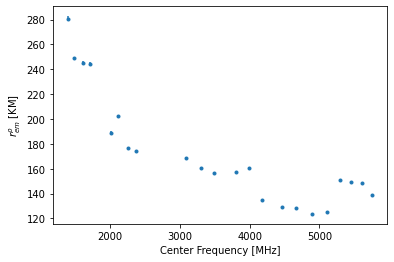

In [64]:
#Results from Rho calculation
y = unp.nominal_values(emission_height_rho)
x_em = freqs
em_uncert = unp.std_devs(emission_height_rho)

plt.errorbar(x_em, y, yerr=em_uncert, fmt='.')
#plt.ylim(bottom=0)
#plt.legend()

#pt.title(r'B0355+54')
plt.xlabel('Center Frequency [MHz]')
plt.ylabel(r'$r_{em}^{\rho}$ [KM]')
#plt.yscale('log')
#plt.xscale('log')
plt.show()
plt.close()

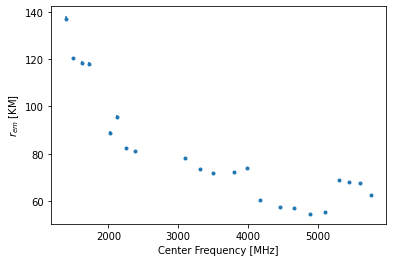

In [65]:
y = unp.nominal_values(emission_height/10000)
#x_em = [1.57, 2.00, 2.43, 3.29, 3.72, 4.15, 4.58, 5.01, 5.44]
x_em = freqs
em_uncert = unp.std_devs(emission_height/10000)
#indexes_to_remove = [0,3]
#y = emission_height_y[np.logical_not(np.isin(np.arange(len(emission_height_y)), indexes_to_remove))]
#em_uncert = emission_height_uncert[np.logical_not(np.isin(np.arange(len(emission_height_uncert)), indexes_to_remove))]

plt.errorbar(x_em, y, yerr=em_uncert, fmt='.')
#plt.ylim(bottom=0)
#plt.legend()
#plt.title('B0355+54')
plt.xlabel('Center Frequency [MHz]')
plt.ylabel(r'$r_{em}$ [KM]')
#plt.yscale('log')
#plt.xscale('log')
plt.show()
plt.close()

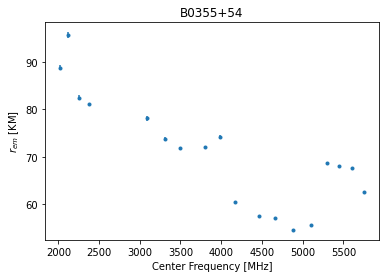

In [66]:
#Calculate without the first 4 values
y2 = unp.nominal_values(emission_height/10000)
#x_em = [1.57, 2.00, 2.43, 3.29, 3.72, 4.15, 4.58, 5.01, 5.44]
x_em2 = freqs
em_uncert2 = unp.std_devs(emission_height/10000)
#indexes_to_remove = [0,3]
#y = emission_height_y[np.logical_not(np.isin(np.arange(len(emission_height_y)), indexes_to_remove))]
#em_uncert = emission_height_uncert[np.logical_not(np.isin(np.arange(len(emission_height_uncert)), indexes_to_remove))]

plt.errorbar(x_em2[4:], y2[4:], yerr=em_uncert2[4:], fmt='.')
#plt.ylim(bottom=0)
#plt.legend()
#plt.yscale('log')
#plt.xscale('log')
plt.title('B0355+54')
plt.xlabel('Center Frequency [MHz]')
plt.ylabel(r'$r_{em}$ [KM]')
plt.show()
plt.close()

------------------------------------------------------

In [67]:
print(freqs)

[1394.725, 1486.598, 1618.861, 1715.667, 2018.846, 2118.637, 2258.035, 2374.394, 3089.807, 3307.711, 3494.584, 3798.033, 3984.424, 4174.934, 4461.355, 4662.833, 4886.906, 5102.516, 5300.529, 5449.154, 5603.586, 5756.508]


In [68]:
#Now calculate the emission height from KG Equation

freqs2 = [u.ufloat(1.57, 0),u.ufloat(2.00, 0),u.ufloat(2.43, 0),u.ufloat(2.86, 0),u.ufloat(3.29, 0),u.ufloat(3.72, 0), \
         u.ufloat(4.15, 0),u.ufloat(4.58, 0),u.ufloat(5.01, 0),u.ufloat(5.44, 0)]
#freqs = 
const = u.ufloat(400, 80) 
ex1 = u.ufloat(-0.26, 0.09) 
ex2 = u.ufloat(0.07, 0.03) 
ex3 = u.ufloat(0.3, 0.05) 
P_dot = u.ufloat(4.39496, 0)

In [69]:
freqs_mhz = [x / 1000 for x in freqs] #Convert to GHz
term1 = np.power(freqs_mhz, ex1)
term2 = np.power(P_dot, ex2)
term3 = np.power(P, ex3)
emission_height_obs = const*term1*term2*term3

In [70]:
print(emission_height_obs)

[233.215601626934+/-52.91260295108679
 229.3793465470731+/-52.23234270228666
 224.35210408951093+/-51.38539253169766
 220.98971062731883+/-50.84658353577452
 211.83504181646535+/-49.48827593157799
 209.19433952405606+/-49.12499210982052
 205.75701872373602+/-48.670465552287915
 203.0864313842857+/-48.33125819745878
 189.64547334367526+/-46.795773088604484
 186.3148485109124+/-46.45579206298542
 183.6715143860339+/-46.19624404741015
 179.73777528127158+/-45.82575766202504
 177.51276564989624+/-45.62402843630238
 175.37017403625066+/-45.43476675019274
 172.37063012601342+/-45.17751326682197
 170.40238489430632+/-45.01326192073022
 168.33553224075578+/-44.84437970831001
 166.4564756356922+/-44.69382261829037
 164.81686032316546+/-44.56460612099059
 163.63608160056214+/-44.47271390115741
 162.45140128702835+/-44.381438879299324
 161.31816134838311+/-44.294941889807355]


In [71]:
#emission_height_obs_list = [230, 210, 200, 190, 190, 180, 180, 170, 170, 160]
#emission_height_obs_err = [50, 50, 50, 50, 50, 50, 50, 50, 40, 40]
emission_height_obs_list = unp.nominal_values(emission_height_obs)
emission_height_obs_err = unp.std_devs(emission_height_obs)

In [72]:
print(np.shape(emission_height_obs_list))
print(np.shape(freqs))

(22,)
(22,)


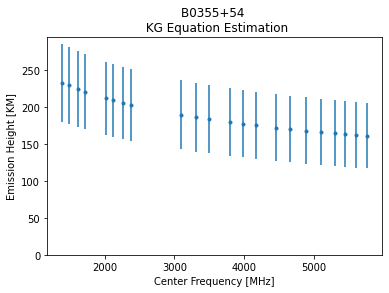

In [73]:
x_em_obs = [1.57, 2.00, 2.43, 3.29, 3.72, 4.15, 4.58, 5.01, 5.44]
plt.errorbar(freqs, emission_height_obs_list, yerr=emission_height_obs_err, fmt='.', linestyle='None')
plt.ylim(bottom=0)
#plt.legend()
plt.title('B0355+54 \n KG Equation Estimation')
plt.xlabel('Center Frequency [MHz]')
plt.ylabel('Emission Height [KM]')
plt.show()
plt.close()